# Análise das medidas do cálculo coerência do conjunto de dados SQUAD 2 P(1,0%) EN.

Realiza a análise dos cálculos de medida de coerência utilizando BERT no SQUAD 2 P(1,0%).

Utiliza os arquivos resultantes da medição de `X` documentos perturbados e `Y` top K predições.

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    estrategia_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4  Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [ ]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Mounted at /content/drive


# 2 Parametrização

## Gerais

In [ ]:
# Nome base das saidas do projeto
NOME_BASE_SAIDA = "MedidaCoerenciaSquad2_P_EN_v1"

# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "SQUAD2_P_EN"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Cálculo das Medidas de (In)coerência

In [ ]:
CONJUNTO_DADOS = 'SQuAD 2'

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  #MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  MODELO_BERT = ['_BERT', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []

  listaTempoTotal = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:                      
                    for estrategia_medida in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  # MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  MODELO_BERT = ['_BERT', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []
    
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:                      
                    for estrategia_medida in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [ ]:
# Parametros para o Cohebert Manual
DOCUMENTOS_PERTURBADOS = [1, 20, 100]
TOP_K_PREDICAO = [1, 20, 100]

# Recupera os melhores parâmetros
MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracao(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [ ]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Modelo BERT           :", MELHOR_MODELO_BERT, 
      "\n  Tamanho BERT          :", MELHOR_TAMANHO_BERT, 
      "\n  Modelo                :", MELHOR_MODELO,     
      "\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Equação               :", MELHOR_EQUACAO_MEDIDA,
      "\n  Estratégia            :", MELHOR_ESTRATEGIA_MEDIDA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Modelo BERT           : _BERT 
  Tamanho BERT          : _large 
  Modelo                : _pretreinado 
  Documentos Perturbados: 1 
  Top k predição        : 1 
  Equação               : _com 
  Estratégia            : _mean 
  Filtro                : _svs 
  Resultado             : 0.7103594080338267 
  Medida                : ccos 
  Tempo execução        : 0:00:13

Lista dos resultados ranqueados
1 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_svs', 0.7103594080338267, 0.5961945031712473, 0.5884425651867512, 'ccos', 0.7103594080338267, '0:00:13']
2 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_max', '_svs', 0.7068357998590556, 0.5926708949964764, 0.5813953488372093, 'ccos', 0.7068357998590556, '0:00:14']
3 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_ssw', 0.689922480620155, 0.5813953488372093, 0.5813953488372093, 'ccos', 0.689922480620155, '0:00:21']
4 = ['_BERT', '_large', '_pretreinado', 

### Escolhendo um resultado diferente do melhor

In [ ]:
# Carrega somente as melhores medidas para Np = 20
MELHOR_DOCUMENTOS_PERTURBADOS = 20
MELHOR_TOP_K_PREDICAO = 20

# Parametros para melhor de 100
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 100
# MELHOR_TOP_K_PREDICAO = 100
# MELHOR_EQUACAO_MEDIDA = '_com'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_tap'
# MELHOR_RESULTADO = 0.7151656095842143
# MELHOR_MEDIDA_GERAL_STR = 'ceuc'
# MELHOR_TEMPO = '1:37:20'
# lista_resultados = []
 
# Parametros para melhor de 20
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 20
# MELHOR_TOP_K_PREDICAO = 20
# MELHOR_EQUACAO_MEDIDA = '_ctx'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_ssw'
# MELHOR_RESULTADO =0.6106060606060606
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = 0:01:49'
# lista_resultados = []

# Parametros para melhor de 1
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_EQUACAO_MEDIDA = '_ctx'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_ssw'
# MELHOR_RESULTADO = 0.6744186046511628
# MELHOR_MEDIDA_GERAL_STR = 'ccos'
# MELHOR_TEMPO = '0:00:11'
# lista_resultados = []

### 3.1.2 Função que carrega os parâmetros do resultado da melhor mensuração

In [ ]:
def carregaMedidasCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

In [ ]:
def carregaMedidas1(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO + ".csv"

  # Diretório para salvar o arquivo.
  DIRETORIO_MEDICAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Medicao/"
  # print("DIRETORIO_MEDICAO:", DIRETORIO_MEDICAO)

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO):    

    # Caminho completo do arquivo
    NOME_ARQUIVO_MEDICAO_COMPLETO = DIRETORIO_MEDICAO + NOME_ARQUIVO_MEDICAO
    # print("NOME_ARQUIVO_MEDICAO_COMPLETO:", NOME_ARQUIVO_MEDICAO_COMPLETO)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_COMPLETO):
      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_COMPLETO, sep=';')

      print('Registros: ', len(dados_medida))

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/SQUAD2_P_EN


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 1419.
INFO:root:TERMINADO ORIGINAIS POS: 1419.


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento,respondivel
613,56fa0002f34c681400b0bf40,['In what geographic part of Somalia were impo...,In what geographic part of Somalia were import...,1
70,56ddcf4166d3e219004dacf9,['What elements of webpages are not used by Wa...,What elements of webpages are not used by Wayb...,1
582,56d103ff17492d1400aab72a,"['Along with Staten Island and the Bronx, what...","Along with Staten Island and the Bronx, what b...",1
986,5a7db92970df9f001a87509b,['What type of radiation does not contribute m...,What type of radiation does not contribute mass?,0
1379,56cd937162d2951400fa6735,['Who saves Midna?'],Who saves Midna?,1


In [ ]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
917,5a8c8e7dfd22b3001a8d8ad5,"[[['What', 'is', 'no', 'longer', 'considered',..."
184,5726a292dd62a815002e8b95,"[[['Who', 'was', 'William', 'Gerard', 'Hamilto..."
630,572745d8f1498d1400e8f590,"[[['Where', 'was', 'the', 'National', 'Confere..."
1142,572a94c7111d821400f38c0f,"[[['How', 'is', 'royal', 'assent', 'granted', ..."
1108,57277f175951b619008f8b60,"[[['What', 'was', 'the', 'name', 'of', 'the', ..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 1419.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 1419.


#### Criando dados indexados originais

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_indexado = lista_documentos_originais.copy()

# Especifica o(s) campo(s) indexado(s)
lista_documentos_originais_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_indexado.head()

,sentencas,documento,respondivel
id,,,
5a8d89b5df8bba001a0f9afb,[Link's Edna form is faster than what other fo...,Link's Edna form is faster than what other form?,0
5acfa4e977cf76001a6856da,[What two ministers fought for power uner Anne?],What two ministers fought for power uner Anne?,0
5ad19f40645df0001a2d213b,[What did Irving Langmuir find that would incr...,What did Irving Langmuir find that would incre...,0
56ce66aeaab44d1400b8875a,[In what year was the crystalline silicon sola...,In what year was the crystalline silicon solar...,1
5acdabd307355d001abf48f0,[Since which year has the idea of a tunnel thr...,Since which year has the idea of a tunnel thro...,0


In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.copy()

# Especifica o(s) campo(s) indexado(s)
lista_documentos_originais_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_pos_indexado.head()

,pos_documento
id,
5a8d89b5df8bba001a0f9afb,"[[[Link, 's, Edna, form, is, faster, than, wha..."
5acfa4e977cf76001a6856da,"[[[What, two, ministers, fought, for, power, u..."
5ad19f40645df0001a2d213b,"[[[What, did, Irving, Langmuir, find, that, wo..."
56ce66aeaab44d1400b8875a,"[[[In, what, year, was, the, crystalline, sili..."
5acdabd307355d001abf48f0,"[[[Since, which, year, has, the, idea, of, a, ..."


#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 28380.
INFO:root:TERMINADO PERTURBADOS POS: 28380.


Alguns csv estão com os nomes das colunas errados

In [ ]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documento_perturbado,sentencas
13594,5728bf3a2ca10214002da6d4_pert_14,['Where was the University of Paris also ?'],Where was the University of Paris also ?,[['Where was the University of Paris [MASK] ?'...
21025,5ad2fda5604f3c001a3fda92_pert_5,['Who proposed the appointment of the Cardinal...,Who proposed the appointment of the Cardinal -...,[['Who [MASK] the appointment of the Cardinal ...
28216,56f86064aef2371900626030_pert_16,['What group of people in addition to wounded ...,What group of people in addition to wounded so...,[['What group of people in addition to wounded...
1331,5ad01c1b77cf76001a686a48_pert_11,['In what year did Vasco da Gama migrate throu...,In what year did Vasco da Gama migrate through...,[['In what year did Vasco da Gama [MASK] throu...
19948,572686ac5951b619008f75ab_pert_8,['In what year did William Maclure beginning t...,In what year did William Maclure beginning the...,[['In what year did William Maclure [MASK] the...


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
2717,56e6c9946fe0821900b8eb72_pert_17,"[[['What', 'type', 'of', 'musicians', 'were', ..."
880,572a4f507a1753140016ae93_pert_0,"[[['In', 'the', 'Soviet', 'section', 'to', 'th..."
14843,572eeb54c246551400ce47a9_pert_3,"[[['How', 'do', 'freight', 'elevators', 'disti..."
26114,573368ba4776f41900660a4b_pert_14,"[[['What', 'did', 'Whitehead', 'find', 'was', ..."
2615,571cc6f85efbb31900334de5_pert_15,"[[['What', 'is', 'the', 'clarity', 'of', 'liqu..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 28380.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 28380.


#### Criando dados indexados perturbados

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.copy()

# Especifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_indexado.head()

,perturbado,documento_perturbado,sentencas
id,,,
5a8d89b5df8bba001a0f9afb_pert_0,[Link 's Edna form is faster than what other f...,Link 's Edna form is faster than what other fo...,[[Link 's Edna [MASK] is faster than what othe...
5a8d89b5df8bba001a0f9afb_pert_1,[Link 's Edna Form is faster than what other f...,Link 's Edna Form is faster than what other fo...,[[Link 's Edna [MASK] is faster than what othe...
5a8d89b5df8bba001a0f9afb_pert_2,[Link 's Edna form is faster than what other f...,Link 's Edna form is faster than what other fo...,[[Link 's Edna [MASK] is faster than what othe...
5a8d89b5df8bba001a0f9afb_pert_3,[Link 's Edna mode is faster than what other f...,Link 's Edna mode is faster than what other fo...,[[Link 's Edna [MASK] is faster than what othe...
5a8d89b5df8bba001a0f9afb_pert_4,[Link 's Edna shape is faster than what other ...,Link 's Edna shape is faster than what other f...,[[Link 's Edna [MASK] is faster than what othe...


In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.copy()

# Especifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_pos_indexado.head()

,pos_documento
id,
5a8d89b5df8bba001a0f9afb_pert_0,"[[[Link, 's, Edna, form, is, faster, than, wha..."
5a8d89b5df8bba001a0f9afb_pert_1,"[[[Link, 's, Edna, Form, is, faster, than, wha..."
5a8d89b5df8bba001a0f9afb_pert_2,"[[[Link, 's, Edna, form, is, faster, than, wha..."
5a8d89b5df8bba001a0f9afb_pert_3,"[[[Link, 's, Edna, mode, is, faster, than, wha..."
5a8d89b5df8bba001a0f9afb_pert_4,"[[[Link, 's, Edna, shape, is, faster, than, wh..."


### 3.2.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

lista_documentos_agrupados = []

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
    #print("linha_documento:",linha_documento)
    # Recupera o id do documento
    id_documento = linha_documento[0]     
    #print("id_documento:",id_documento)     
 
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento[1]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
    lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
  
    # Percorre os documentos perturbados apartir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

      # Id do documento perturbado
      id_perturbado = str(id_documento) + "_pert_" + str(j)

      # localiza o documento perturbado 
      #documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
      documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
      # Recupera a sentença do documento perturbado
      lista_perturbado = documento_perturbado[0]
          
      # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
      lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

Processando 1419 documentos originais


Documentos:   0%|          | 0/1419 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 29799.


Converte em um dataframe

In [ ]:
# Cria o dataframe da lista
df_lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

df_lista_documentos_agrupados = df_lista_documentos_agrupados.astype(tipos)

In [ ]:
df_lista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
18880,5ace376a32bba1001ae49ed0_pert_0,[Sony and Michael Jordan in a joint venture in...,Sony and Michael Jordan in a joint venture in ...,0
25722,5709b6d7ed30961900e8444f_pert_17,[What was the highest building in Houston cons...,What was the highest building in Houston consi...,0
20491,5a14d7f2a54d420018529381_pert_15,[What are the five permanent Security Council ...,What are the five permanent Security Council M...,0
29611,56f86064aef2371900626030_pert_0,[What group of people in addition to wounded s...,What group of people in addition to wounded so...,0
16030,572635e3271a42140099d78a_pert_6,[How can a champion earn a championship ?],How can a champion earn a championship ?,0


In [ ]:
# Importa das bibliotecas
import pandas as pd

# Concatena as listas de documentos originais e perturbados
df_lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(df_lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 29799.


In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

df_lista_documentos_agrupados_pos = df_lista_documentos_agrupados_pos.astype(tipos)

In [ ]:
df_lista_documentos_agrupados_pos.sample(5)

,id,pos_documento
4851,570c4b09fed7b91900d4584f_pert_11,"[[[When, did, Joan, Gamper, succeed, the, pres..."
28195,5726890bdd62a815002e887c_pert_15,"[[[What, compression, typically, operate, on, ..."
519,5a5a48ea9c0277001abe70f3,"[[[What, form, of, music, combined, the, clean..."
26854,57266bc1708984140094c575_pert_14,"[[[Which, country, conquered, Florida, from, S..."
11365,5ad690ae191832001aa7b220_pert_5,"[[[What, is, the, uncommon, density, of, carbo..."


#### Criar dados indexados

In [ ]:
lista_documentos_agrupados_indexado = df_lista_documentos_agrupados.copy()

# Especifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_indexado.head()

,sentencas,documento,classe
id,,,
5a8d89b5df8bba001a0f9afb,[Link's Edna form is faster than what other fo...,Link's Edna form is faster than what other form?,1
5a8d89b5df8bba001a0f9afb_pert_0,[Link 's Edna form is faster than what other f...,Link 's Edna form is faster than what other fo...,0
5a8d89b5df8bba001a0f9afb_pert_1,[Link 's Edna Form is faster than what other f...,Link 's Edna Form is faster than what other fo...,0
5a8d89b5df8bba001a0f9afb_pert_2,[Link 's Edna form is faster than what other f...,Link 's Edna form is faster than what other fo...,0
5a8d89b5df8bba001a0f9afb_pert_3,[Link 's Edna mode is faster than what other f...,Link 's Edna mode is faster than what other fo...,0


In [ ]:
# Faz uma cópia da lista não indexada
df_lista_documentos_agrupados_pos_indexado = df_lista_documentos_agrupados_pos.copy()

# Especifica o(s) campo(s) indexado(s)
df_lista_documentos_agrupados_pos_indexado.set_index(["id"], inplace=True)
df_lista_documentos_agrupados_pos_indexado.head()

,pos_documento
id,
5a8d89b5df8bba001a0f9afb,"[[[Link, 's, Edna, form, is, faster, than, wha..."
5acfa4e977cf76001a6856da,"[[[What, two, ministers, fought, for, power, u..."
5ad19f40645df0001a2d213b,"[[[What, did, Irving, Langmuir, find, that, wo..."
56ce66aeaab44d1400b8875a,"[[[In, what, year, was, the, crystalline, sili..."
5acdabd307355d001abf48f0,"[[[Since, which, year, has, the, idea, of, a, ..."


## 3.3 Carregando o resultado da melhor mensuração

In [ ]:
# MODELO_BERT = [MELHOR_MODELO_BERT]
# TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
# MODELO = [MELHOR_MODELO] 
# DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
# TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
# EQUACAO_MEDIDA = [MELHOR_EQUACAO_MEDIDA]
# ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
# FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

# dados_mensuracao = carregaMedidasCompactada(MELHOR_MODELO_BERT, 
#                                  MELHOR_TAMANHO_BERT,
#                                  MELHOR_MODELO,
#                                  MELHOR_DOCUMENTOS_PERTURBADOS, 
#                                  MELHOR_TOP_K_PREDICAO,
#                                  MELHOR_EQUACAO_MEDIDA,
#                                  MELHOR_ESTRATEGIA_MEDIDA,
#                                  MELHOR_FILTRO_PALAVRAS)

### Carrega as melhores de cada equação(CAW, CWP,CG) para Np = 20

In [ ]:
# MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
MODELO_BERT = ['_BERT', '_BERTmultilingual']
TAMANHO_BERT = ['_base','_large']
MODELO = ['_pretreinado', '_ajustado'] 
DOCUMENTOS_PERTURBADOS = [1,20,100]
TOP_K_PREDICAO = [1,20,100]
EQUACAO_MEDIDA = ['_adj','_com','_ctx'] # ['CAW - palavras adjacentes','CWP - combinação de todas as palavras','CG - contexto global']
ESTRATEGIA_MEDIDA = ['_mean', '_max']
FILTRO_PALAVRA = ['_tap','_ssw', '_ssb']  #['TODAS_AS_PALAVRAS', 'SEM_STOPWORDS', 'SOMENTE_SUBSTANTIVOS']  

# Muda somente o carregamento da equação
dados_mensuracaoCAW = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20  
                                    EQUACAO_MEDIDA[0], #CAW
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCWP = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1],#20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[1], #CWP
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCG = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[2], #CG
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

print("Registros CAW:", len(dados_mensuracaoCAW))
print("Registros CWP:", len(dados_mensuracaoCWP))
print("Registros  CG:", len(dados_mensuracaoCG))

INFO:root:Diretório criado: /content/SQUAD2_P_EN/Medicao/.
INFO:root:Diretório já existe: /content/SQUAD2_P_EN/Medicao/.


Arquivo encontrado e carregado


INFO:root:Diretório já existe: /content/SQUAD2_P_EN/Medicao/.


Arquivo encontrado e carregado
Arquivo encontrado e carregado
Registros CAW: 56760
Registros CWP: 56760
Registros  CG: 56760


In [ ]:
dados_mensuracaoCAW.sample(5)

,data,arquivo,ccos,ceuc,cman
9808,17/08/2022 18:31,5728e578ff5b5019007da8f7,0.597732,39.070351,1957.735518
26367,17/08/2022 18:31,56e0f1b0231d4119001ac48b_pert_3,0.673473,34.696779,1729.555070
17756,17/08/2022 18:31,57276430dd62a815002e9c07,0.634016,38.162463,1910.677600
39424,17/08/2022 18:31,5a8456db7cf838001a46a75e,0.612436,38.635308,1941.231215
43114,17/08/2022 18:31,572798dddd62a815002ea189,0.638474,36.779626,1844.308057


In [ ]:
dados_mensuracaoCWP.sample(5)

,data,arquivo,ccos,ceuc,cman
55507,17/08/2022 19:00,5a513e8ece860b001aa3fc7e_pert_13,0.569674,42.058040,2109.891928
45404,17/08/2022 19:00,572fdb17b2c2fd140056851e,0.541142,42.701104,2136.071036
47655,17/08/2022 19:00,5ad26061d7d075001a428fcf_pert_7,0.594010,38.571610,1914.677060
13578,17/08/2022 19:00,572813e23acd2414000df3e6,0.524457,43.466623,2192.688287
2923,17/08/2022 19:00,5a8ddf58df8bba001a0f9ce0_pert_1,0.551921,41.255284,2057.706627


In [ ]:
dados_mensuracaoCG.sample(5)

,data,arquivo,ccos,ceuc,cman
2265,17/08/2022 19:39,5728cab72ca10214002da7f1_pert_12,0.785011,27.235124,1366.665700
47874,17/08/2022 19:39,5732388ae99e3014001e6599,0.776829,26.763759,1311.345867
31069,17/08/2022 19:39,572f9e5504bcaa1900d76aeb_pert_14,0.784084,27.628456,1380.310383
28502,17/08/2022 19:39,5a5fe5d0eae51e001ab14cfb,0.738299,30.596423,1528.151261
28390,17/08/2022 19:39,571aa2cb4faf5e1900b8ab77,0.793739,26.801904,1340.005555


In [ ]:
def getMedidasDocumento(df_dados_medida, id_documento):
  
  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_dados_medida = df_dados_medida.set_index(["arquivo"])

  # Separa os originais
  #df_medida = df_dados_medida.loc[df_dados_medida['arquivo']==id_documento]
  df_medida = df_dados_medida.loc[id_documento]
  
  return df_medida['ccos'],df_medida['ceuc'],df_medida['cman'],

### Separa os documentos e remove as repetições

In [ ]:
def separaDocumentos(dados_medida):
  
  # Separa os originais
  df_original_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==False]
  # Remove os duplicados
  df_original_medida = df_original_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Originais: ', len(df_original_medida))

  # Separa os perturbados
  df_perturbado_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==True]
  # Remove os duplicados
  df_perturbado_medida = df_perturbado_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Perturbados: ', len(df_perturbado_medida))

  return df_original_medida, df_perturbado_medida  

In [ ]:
df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW = separaDocumentos(dados_mensuracaoCAW)
df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP = separaDocumentos(dados_mensuracaoCWP)
df_original_mesuracaoCG, df_perturbado_mesuracaoCG = separaDocumentos(dados_mensuracaoCG)

Registros Originais:  1419
Registros Perturbados:  28380
Registros Originais:  1419
Registros Perturbados:  28380
Registros Originais:  1419
Registros Perturbados:  28380


### Organiza os pares de documentos

In [ ]:
def organizaParesDocumentos(df_original_medida, df_perturbado_medida):

  # Import das bibliotecas.
  import pandas as pd

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_perturbado_medida_indexado = df_perturbado_medida.set_index(["arquivo"])
  df_perturbado_medida_indexado.head()

  lista_pares_documentos_medidas = []
  # Refaz os pares de documentos
  for i, documento_orirginal in df_original_medida.iterrows():

    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):

      nome_arquivo_perturbado = str(documento_orirginal['arquivo']) + "_pert_" + str(j)

      documento_perturbado = df_perturbado_medida_indexado.loc[nome_arquivo_perturbado]

      lista_pares_documentos_medidas.append(
                                      [documento_orirginal['data'], 
                                       documento_orirginal['arquivo'],	
                                       documento_orirginal['ccos'], 
                                       documento_orirginal['ceuc'], 
                                       documento_orirginal['cman'],
                                       
                                       documento_perturbado['data'], 
                                       nome_arquivo_perturbado, 	
                                       documento_perturbado['ccos'], 
                                       documento_perturbado['ceuc'], 
                                       documento_perturbado['cman']])

  print('Registros antes:', len(lista_pares_documentos_medidas))

  df_lista_pares_documentos_medidas = pd.DataFrame(lista_pares_documentos_medidas, columns=('data_DO', 
                                                                                     'id_DO',
                                                                                     'ccos_DO', 
                                                                                     'ceuc_DO', 
                                                                                     'cman_DO', 
                                                                                     'data_pertDO', 
                                                                                     'id_pertDO', 
                                                                                     'ccos_pertDO', 
                                                                                     'ceuc_pertDO', 
                                                                                     'cman_pertDO')) 
  
  print('Registros depois:', len(df_lista_pares_documentos_medidas))

  return df_lista_pares_documentos_medidas

In [ ]:
df_lista_pares_documentos_mensuracaoCAW = organizaParesDocumentos(df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW)
df_lista_pares_documentos_mensuracaoCWP = organizaParesDocumentos(df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP)
df_lista_pares_documentos_mensuracaoCG = organizaParesDocumentos(df_original_mesuracaoCG, df_perturbado_mesuracaoCG)

Registros antes: 28380
Registros depois: 28380
Registros antes: 28380
Registros depois: 28380
Registros antes: 28380
Registros depois: 28380


In [ ]:
df_lista_pares_documentos_mensuracaoCAW.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
21207,17/08/2022 18:31,56d523bd2593cc1400307aaa,0.668107,35.632657,1788.276433,17/08/2022 18:31,56d523bd2593cc1400307aaa_pert_7,0.668506,35.265011,1764.383622
12125,17/08/2022 18:31,57269016708984140094ca41,0.555636,39.771315,1874.488818,17/08/2022 18:31,57269016708984140094ca41_pert_5,0.555664,39.822455,1877.824918
4979,17/08/2022 18:31,5a7e50c270df9f001a875702,0.519195,43.676847,2200.705600,17/08/2022 18:31,5a7e50c270df9f001a875702_pert_19,0.544368,41.726798,2098.081600
24851,17/08/2022 18:31,572846aa4b864d1900164895,0.616376,39.227270,1962.433514,17/08/2022 18:31,572846aa4b864d1900164895_pert_11,0.635603,37.483968,1864.311657
17689,17/08/2022 18:31,572933aa3f37b319004780fa,0.645736,37.476818,1874.810386,17/08/2022 18:31,572933aa3f37b319004780fa_pert_9,0.647942,37.291171,1868.933600


In [ ]:
df_lista_pares_documentos_mensuracaoCWP.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
9988,17/08/2022 19:00,5a8308fde60761001a2eb320,0.534645,43.752912,2209.822542,17/08/2022 19:00,5a8308fde60761001a2eb320_pert_8,0.543239,42.621931,2144.775198
1796,17/08/2022 19:00,5727774b5951b619008f8a8b,0.541693,42.729735,2158.771602,17/08/2022 19:00,5727774b5951b619008f8a8b_pert_16,0.510154,44.809658,2264.087058
12813,17/08/2022 19:00,5727aa413acd2414000de921,0.538933,43.292932,2185.508121,17/08/2022 19:00,5727aa413acd2414000de921_pert_13,0.545024,42.473563,2132.294807
11490,17/08/2022 19:00,5a10fcfd06e79900185c34b1,0.483855,43.702276,2055.500989,17/08/2022 19:00,5a10fcfd06e79900185c34b1_pert_10,0.557993,41.252128,2079.989602
10938,17/08/2022 19:00,57313b9a497a881900248ca7,0.523226,43.651373,2196.978032,17/08/2022 19:00,57313b9a497a881900248ca7_pert_18,0.475195,44.573333,2165.957116


In [ ]:
df_lista_pares_documentos_mensuracaoCG.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
10314,17/08/2022 19:39,572a80b8111d821400f38b70,0.793852,26.573045,1327.381850,17/08/2022 19:39,572a80b8111d821400f38b70_pert_14,0.796918,26.339289,1312.838475
18475,17/08/2022 19:39,572973f76aef051400154f0b,0.732007,29.079031,1388.168277,17/08/2022 19:39,572973f76aef051400154f0b_pert_15,0.779155,28.388532,1421.978166
20380,17/08/2022 19:39,5ad134d3645df0001a2d1162,0.776352,27.662206,1389.859329,17/08/2022 19:39,5ad134d3645df0001a2d1162_pert_0,0.776352,27.662206,1389.859329
26948,17/08/2022 19:39,5725cf3238643c19005acd61,0.798427,25.844175,1307.548900,17/08/2022 19:39,5725cf3238643c19005acd61_pert_8,0.819365,24.355897,1236.641783
11722,17/08/2022 19:39,5acfc4d477cf76001a685dfb,0.796518,26.453702,1328.627590,17/08/2022 19:39,5acfc4d477cf76001a685dfb_pert_2,0.787105,27.166668,1368.950520


### Retorna as medidas de um documento pelo seu índice

Uma uma lista ordenada de medidas pelo DO e depois pelo pertDO da medida

In [ ]:
def getDocumentoPeloIndiceEmMedidas(lista_medidas_documento, indice_documento_original, medida = "cos"):

  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medida_documento = lista_medidas_documento_ordenado.iloc[indice_documento_original]
  # print("medida_documento:",medida_documento)

  id_documento_original = str(medida_documento['id_DO'])
  # print("id_documento_original:", id_documento_original)

  documento = lista_documentos_originais_indexado.loc[id_documento_original]
  
  return id_documento_original, documento

In [ ]:
def getMedidasParesDocumento(lista_medidas_documento, indice_documento_original, medida = "cos"):

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  lista_medidas_documento = lista_medidas_documento.set_index(["id_DO"])
    
  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medidas_documento = lista_medidas_documento_ordenado.loc[indice_documento_original]
  print("medida_documentos:",len(medidas_documento))
      
  return medidas_documento

## 3.4 Estatísticas das Medidas

### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [ ]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCAW = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCAW,
                                                               MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCAW))

Equação CAW para a medida para : ccos
lista_retorno_medido_corretamente: 30236


In [ ]:
print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCWP = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCWP,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCWP))

Equação CWP para a medida para : ccos
lista_retorno_medido_corretamente: 28714


In [ ]:
print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCG = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCG,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCG))

Equação CG para a medida para : ccos
lista_retorno_medido_corretamente: 28522


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [ ]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCAW = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCAW,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCAW))

print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCWP = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCWP,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCWP))

print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCG = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCG,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCG))

Equação CAW para a medida para : ccos
lista_retorno_medido_incorretamente: 26524
Equação CWP para a medida para : ccos
lista_retorno_medido_incorretamente: 28046
Equação CG para a medida para : ccos
lista_retorno_medido_incorretamente: 28238


#### Acertos das listas

In [ ]:
print("Equação CAW")
total = len(lista_retorno_medido_corretamenteCAW) + len(lista_retorno_medido_incorretamenteCAW)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCAW))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCAW))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCAW)/total)

Equação CAW
Total de documentos: 56760
Total de acertos   : 30236
Total de erros     : 26524
Percentual acerto  : 0.5326990838618746


In [ ]:
print("Equação CWP")
total = len(lista_retorno_medido_corretamenteCWP) + len(lista_retorno_medido_incorretamenteCWP)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCWP))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCWP))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCWP)/total)

Equação CWP
Total de documentos: 56760
Total de acertos   : 28714
Total de erros     : 28046
Percentual acerto  : 0.5058844256518675


In [ ]:
print("Equação CG")
total = len(lista_retorno_medido_corretamenteCG) + len(lista_retorno_medido_incorretamenteCG)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCG))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCG))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCG)/total)

Equação CG
Total de documentos: 56760
Total de acertos   : 28522
Total de erros     : 28238
Percentual acerto  : 0.5025017618040873


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_corretamenteCAW))
lista_retorno_medido_corretamente_sem_repeticaoCAW = lista_retorno_medido_corretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_corretamenteCAW))

Com repetição: 30236
Sem repetição: 30236


Remove as duplicidades dos dados perturbados.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_incorretamenteCAW))
lista_retorno_medido_incorretamente_sem_repeticaoCAW = lista_retorno_medido_incorretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_incorretamente_sem_repeticaoCAW))

Com repetição: 26524
Sem repetição: 14581


#### Listas documentos originais e perturbados medidos corretamente

In [ ]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(lista_retorno_medido_corretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_corretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:

    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 30236
    1 Link's Edna form is faster than what other form? 1
    2 Link 's Edna form is faster than what other form ? 0
    3 Link's Edna form is faster than what other form? 1
    4 Link 's Edna Form is faster than what other form ? 0
    5 Link's Edna form is faster than what other form? 1
    6 Link 's Edna form is faster than what other form ? 0
    7 Link's Edna form is faster than what other form? 1
    8 Link 's Edna Mode is faster than what other form ? 0
    9 Link's Edna form is faster than what other form? 1
    10 Link 's Edna n is faster than what other form ? 0


#### Listas documentos originais e perturbados medidos incorretamente

In [ ]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(lista_retorno_medido_incorretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_incorretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:        
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]           
    
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 26524
    1 Link's Edna form is faster than what other form? 1
    2 Link 's Edna mode is faster than what other form ? 0
    3 Link's Edna form is faster than what other form? 1
    4 Link 's Edna shape is faster than what other form ? 0
    5 Link's Edna form is faster than what other form? 1
    6 Link 's Edna r is faster than what other form ? 0
    7 Link's Edna form is faster than what other form? 1
    8 Link 's Edna ge is faster than what other form ? 0
    9 Link's Edna form is faster than what other form? 1
    10 Link 's Edna p is faster than what other form ? 0


### Listas

#### Lista de documentos originais(1) medidos corretamente(1)

In [ ]:
def listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_corretamenteCAW = listaOriginalMedidoCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)
print('lista_documento_original_medido_corretamente:', len(lista_documento_original_medido_corretamenteCAW))

lista_documento_original_medido_corretamente: 15118


In [ ]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(lista_documento_original_medido_corretamenteCAW))
for i, documento in lista_documento_original_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)): 15118
   0 - Link's Edna form is faster than what other form? 1
   1 - Link's Edna form is faster than what other form? 1
   2 - Link's Edna form is faster than what other form? 1
   3 - Link's Edna form is faster than what other form? 1
   4 - Link's Edna form is faster than what other form? 1
   5 - Link's Edna form is faster than what other form? 1
   6 - Link's Edna form is faster than what other form? 1
   7 - Link's Edna form is faster than what other form? 1
   8 - What two ministers fought for power uner Anne? 1
   9 - What two ministers fought for power uner Anne? 1


#### Lista de documento originais(1) medidos incorretamente(0)

In [ ]:
def listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_incorretamenteCAW = listaOriginalMedidoIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(lista_documento_original_medido_incorretamenteCAW))

Lista de documentos originais medidos incorretamente: 13262


In [ ]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)):", len(lista_documento_original_medido_incorretamenteCAW))
for i, documento in lista_documento_original_medido_incorretamenteCAW.iterrows():
  if i < 10:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)): 13262
   0 - Link's Edna form is faster than what other form? 1
   1 - Link's Edna form is faster than what other form? 1
   2 - Link's Edna form is faster than what other form? 1
   3 - Link's Edna form is faster than what other form? 1
   4 - Link's Edna form is faster than what other form? 1
   5 - Link's Edna form is faster than what other form? 1
   6 - Link's Edna form is faster than what other form? 1
   7 - Link's Edna form is faster than what other form? 1
   8 - Link's Edna form is faster than what other form? 1
   9 - Link's Edna form is faster than what other form? 1


#### Lista Documentos Perturbados(0) medidos corretamente(0)

In [ ]:
def listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_corretamenteCAW  = listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(lista_documento_perturbado_medido_corretamenteCAW))

Lista de documentos perturbados medidos corretamente: 13262


In [ ]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(lista_documento_perturbado_medido_corretamenteCAW))
for i, documento in lista_documento_perturbado_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)): 13262
   0 - Link 's Edna mode is faster than what other form ? 0
   1 - Link 's Edna shape is faster than what other form ? 0
   2 - Link 's Edna r is faster than what other form ? 0
   3 - Link 's Edna ge is faster than what other form ? 0
   4 - Link 's Edna p is faster than what other form ? 0
   5 - Link 's Edna speed is faster than what other form ? 0
   6 - Link 's Edna m is faster than what other form ? 0
   7 - Link 's Edna bit is faster than what other form ? 0
   8 - Link 's Edna body is faster than what other form ? 0
   9 - Link 's Edna k is faster than what other form ? 0


#### Lista Documentos Perturbados(0) medidos  incorretamente(1)

In [ ]:
def listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_incorretamenteCAW = listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(lista_documento_perturbado_medido_incorretamenteCAW))

Lista de documentos perturbados medidos incorretamente: 15118


In [ ]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(lista_documento_perturbado_medido_incorretamenteCAW))
for i, documento in lista_documento_perturbado_medido_incorretamenteCAW.iterrows():
  if i < 10:  
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 15118
   0 - Link 's Edna form is faster than what other form ? 0
   1 - Link 's Edna Form is faster than what other form ? 0
   2 - Link 's Edna form is faster than what other form ? 0
   3 - Link 's Edna Mode is faster than what other form ? 0
   4 - Link 's Edna n is faster than what other form ? 0
   5 - Link 's Edna sense is faster than what other form ? 0
   6 - Link 's Edna version is faster than what other form ? 0
   7 - Link 's Edna h is faster than what other form ? 0
   8 - What two ministers fought for power uner Anne ? 0
   9 - What two ministers struggle for power uner Anne ? 0


### Estatísticas medidas documentos coerentes e incoerentes

In [ ]:
def geraEstatisticas(df_lista_pares_documentos_medidas):

  # Lista das estatísticas das medidas
  stats_medidas_documentos = []

  for i, linha in df_lista_pares_documentos_medidas.iterrows():
      
      # Registra as estatística da comparação
      stats_medidas_documentos.append(
        {  
          'documento': i,                  
          'original ccos': linha['ccos_DO'],
          'perturbado ccos': linha['ccos_pertDO'],
          'dif ccos' : linha['ccos_DO'] - linha['ccos_pertDO'],
          'difabs ccos' : abs(linha['ccos_DO'] - linha['ccos_pertDO']),
          'original ceuc': linha['ceuc_DO'],
          'perturbado ceuc': linha['ceuc_pertDO'],
          'dif ceuc' : linha['ceuc_DO'] - linha['ceuc_pertDO'],
          'difabs ceuc' : abs(linha['ceuc_DO'] - linha['ceuc_pertDO']),
          'original cman': linha['cman_DO'],
          'perturbado cman': linha['cman_pertDO'],
          'dif cman' : linha['cman_DO'] - linha['cman_pertDO'],
          'difabs cman' : abs(linha['cman_DO'] - linha['cman_pertDO']),
        }
      )     
  return stats_medidas_documentos

In [ ]:
stats_mensuracao_documentos_CAW = geraEstatisticas(df_lista_pares_documentos_mensuracaoCAW)
stats_mensuracao_documentos_CWP = geraEstatisticas(df_lista_pares_documentos_mensuracaoCWP)
stats_mensuracao_documentos_CG = geraEstatisticas(df_lista_pares_documentos_mensuracaoCG)

Estatísticas de todas as Medidas

Define o formato de exibição dos números reais no dataframe.

In [ ]:
# Import das bibliotecas
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.8f' %x)

Equação CAW

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000
mean,14189.50000000,0.59277381,0.59426251,-0.00148871,0.02122339,39.62216529,39.55628786,0.06587743,1.10132256,1959.89072352,1959.72758692,0.16313659,48.84095330
std,8192.74465610,0.05187464,0.05023541,0.03479223,0.02760920,2.58636647,2.55087787,1.58883106,1.14707018,117.82737346,117.70873971,67.97148184,47.27183286
min,0.00000000,0.33410771,0.30596716,-0.28271935,0.00000000,31.36723804,27.67705504,-9.67573847,0.00000000,1556.51803333,1380.08951667,-403.87400000,0.00000000
25%,7094.75000000,0.56579147,0.56642358,-0.01252130,0.00501849,37.87045956,37.86459411,-0.72291067,0.30441183,1879.73135000,1881.71282500,-35.99330729,14.60624000
50%,14189.50000000,0.59834088,0.59928095,0.00000000,0.01229836,39.61553125,39.58579874,0.00000000,0.75402343,1964.13261667,1961.70147625,0.00000000,35.47304167
75%,21284.25000000,0.62864919,0.62849302,0.01211940,0.02518908,41.33307076,41.23878253,0.78602638,1.50759616,2034.01230000,2038.49198259,34.94596339,68.49506625
max,28379.00000000,0.72572339,0.77574816,0.23215083,0.28271935,49.67592367,49.70230230,11.54406112,11.54406112,2320.51964000,2400.90730000,586.70348571,586.70348571


Equação CWP

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000
mean,14189.50000000,0.54166002,0.54368150,-0.00202148,0.01850239,42.20611738,42.11347491,0.09264247,0.95055938,2092.23348065,2090.53301004,1.70047061,44.53668295
std,8192.74465610,0.04596000,0.04499850,0.02910914,0.02256276,2.37738121,2.35898866,1.35057006,0.96386070,112.88210878,112.77524022,62.32441446,43.63070384
min,0.00000000,0.35969586,0.35673678,-0.20325033,0.00000000,33.06786401,31.48855178,-8.03162766,0.00000000,1637.24326190,1530.07695000,-402.85562857,0.00000000
25%,7094.75000000,0.51504802,0.51652444,-0.01245104,0.00446627,40.59893468,40.52639299,-0.58550546,0.27498300,2021.33162889,2017.71685903,-30.73654965,13.47697587
50%,14189.50000000,0.54617956,0.54659736,0.00000000,0.01116831,42.18688085,42.19679785,0.00861900,0.66671787,2094.22110018,2094.05666557,0.00000000,32.31557427
75%,21284.25000000,0.57219380,0.57465860,0.01002739,0.02306463,43.86066786,43.75911769,0.74802944,1.31063373,2168.59572051,2166.52808167,33.83251837,62.19503891
max,28379.00000000,0.68581254,0.71285618,0.19019128,0.20325033,49.80958557,51.44670665,9.55670459,9.55670459,2432.17482222,2555.93766667,493.10250000,493.10250000


Equação CG

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000,28380.00000000
mean,14189.50000000,0.75996091,0.76164434,-0.00168343,0.01207103,28.41072955,28.34459016,0.06613938,0.63035678,1407.51440532,1406.25074090,1.26366442,29.54341214
std,8192.74465610,0.03712238,0.03606017,0.02066771,0.01686040,1.84953123,1.84757891,0.89129722,0.63357844,86.28981824,86.82216188,41.16592749,28.69471265
min,0.00000000,0.60478072,0.58104484,-0.17381510,0.00000000,21.71638031,19.31148338,-5.24346406,0.00000000,1086.36776800,942.89530000,-271.68838571,0.00000000
25%,7094.75000000,0.74136103,0.74299166,-0.00753229,0.00268125,27.24521976,27.15215932,-0.38668927,0.18443754,1355.07863333,1352.55325500,-20.43697222,9.04649625
50%,14189.50000000,0.76584258,0.76628993,0.00000000,0.00666138,28.45711463,28.43379653,0.00799222,0.44780440,1411.81509231,1412.24224583,0.00000000,21.55956514
75%,21284.25000000,0.78450253,0.78578118,0.00586993,0.01362503,29.75040739,29.65037785,0.50650381,0.87213202,1467.92637500,1464.18005913,22.68349531,41.33436000
max,28379.00000000,0.85861965,0.88249072,0.14415068,0.17381510,34.37427323,35.06856537,6.34687042,6.34687042,1675.01621071,1716.11992000,321.83291250,321.83291250


### Estatísticas de todas as Medidas(Transposta)

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,28380.00000000,14189.50000000,8192.74465610,0.00000000,7094.75000000,14189.50000000,21284.25000000,28379.00000000
original ccos,28380.00000000,0.59277381,0.05187464,0.33410771,0.56579147,0.59834088,0.62864919,0.72572339
perturbado ccos,28380.00000000,0.59426251,0.05023541,0.30596716,0.56642358,0.59928095,0.62849302,0.77574816
dif ccos,28380.00000000,-0.00148871,0.03479223,-0.28271935,-0.01252130,0.00000000,0.01211940,0.23215083
difabs ccos,28380.00000000,0.02122339,0.02760920,0.00000000,0.00501849,0.01229836,0.02518908,0.28271935
original ceuc,28380.00000000,39.62216529,2.58636647,31.36723804,37.87045956,39.61553125,41.33307076,49.67592367
perturbado ceuc,28380.00000000,39.55628786,2.55087787,27.67705504,37.86459411,39.58579874,41.23878253,49.70230230
dif ceuc,28380.00000000,0.06587743,1.58883106,-9.67573847,-0.72291067,0.00000000,0.78602638,11.54406112
difabs ceuc,28380.00000000,1.10132256,1.14707018,0.00000000,0.30441183,0.75402343,1.50759616,11.54406112
original cman,28380.00000000,1959.89072352,117.82737346,1556.51803333,1879.73135000,1964.13261667,2034.01230000,2320.51964000


In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,28380.00000000,14189.50000000,8192.74465610,0.00000000,7094.75000000,14189.50000000,21284.25000000,28379.00000000
original ccos,28380.00000000,0.54166002,0.04596000,0.35969586,0.51504802,0.54617956,0.57219380,0.68581254
perturbado ccos,28380.00000000,0.54368150,0.04499850,0.35673678,0.51652444,0.54659736,0.57465860,0.71285618
dif ccos,28380.00000000,-0.00202148,0.02910914,-0.20325033,-0.01245104,0.00000000,0.01002739,0.19019128
difabs ccos,28380.00000000,0.01850239,0.02256276,0.00000000,0.00446627,0.01116831,0.02306463,0.20325033
original ceuc,28380.00000000,42.20611738,2.37738121,33.06786401,40.59893468,42.18688085,43.86066786,49.80958557
perturbado ceuc,28380.00000000,42.11347491,2.35898866,31.48855178,40.52639299,42.19679785,43.75911769,51.44670665
dif ceuc,28380.00000000,0.09264247,1.35057006,-8.03162766,-0.58550546,0.00861900,0.74802944,9.55670459
difabs ceuc,28380.00000000,0.95055938,0.96386070,0.00000000,0.27498300,0.66671787,1.31063373,9.55670459
original cman,28380.00000000,2092.23348065,112.88210878,1637.24326190,2021.33162889,2094.22110018,2168.59572051,2432.17482222


In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,28380.00000000,14189.50000000,8192.74465610,0.00000000,7094.75000000,14189.50000000,21284.25000000,28379.00000000
original ccos,28380.00000000,0.75996091,0.03712238,0.60478072,0.74136103,0.76584258,0.78450253,0.85861965
perturbado ccos,28380.00000000,0.76164434,0.03606017,0.58104484,0.74299166,0.76628993,0.78578118,0.88249072
dif ccos,28380.00000000,-0.00168343,0.02066771,-0.17381510,-0.00753229,0.00000000,0.00586993,0.14415068
difabs ccos,28380.00000000,0.01207103,0.01686040,0.00000000,0.00268125,0.00666138,0.01362503,0.17381510
original ceuc,28380.00000000,28.41072955,1.84953123,21.71638031,27.24521976,28.45711463,29.75040739,34.37427323
perturbado ceuc,28380.00000000,28.34459016,1.84757891,19.31148338,27.15215932,28.43379653,29.65037785,35.06856537
dif ceuc,28380.00000000,0.06613938,0.89129722,-5.24346406,-0.38668927,0.00799222,0.50650381,6.34687042
difabs ceuc,28380.00000000,0.63035678,0.63357844,0.00000000,0.18443754,0.44780440,0.87213202,6.34687042
original cman,28380.00000000,1407.51440532,86.28981824,1086.36776800,1355.07863333,1411.81509231,1467.92637500,1675.01621071


### Divide os pares das medidas das equações em listas 





In [ ]:
def divideMedidas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original 
  lista_medida_original = [linha[medida + '_DO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]
  
  # Medida do documento perturbado
  lista_medida_perturbado = [linha[medida + '_pertDO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  return lista_medida_original, lista_medida_perturbado

In [ ]:
# Equações CAW
lista_original_CcosCAW, lista_perturbado_CcosCAW = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CcosCAW), len(lista_perturbado_CcosCAW))

lista_original_CeucCAW, lista_perturbado_CeucCAW = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CeucCAW), len(lista_perturbado_CeucCAW))

lista_original_CmanCAW, lista_perturbado_CmanCAW = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CmanCAW), len(lista_perturbado_CmanCAW))

# Equações CWP
lista_original_CcosCWP, lista_perturbado_CcosCWP = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_CeucCWP, lista_perturbado_CeucCWP = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CeucCWP), len(lista_perturbado_CeucCWP))

lista_original_CmanCWP, lista_perturbado_CmanCWP = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CmanCWP), len(lista_perturbado_CmanCWP))

# Equações CG
lista_original_CcosCG, lista_perturbado_CcosCG = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CcosCG), len(lista_perturbado_CcosCG))

lista_original_CeucCG, lista_perturbado_CeucCG = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CeucCG), len(lista_perturbado_CeucCG))

lista_original_CmanCG, lista_perturbado_CmanCG = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CmanCG), len(lista_perturbado_CmanCG))


28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380


### Divide os pares das medidas das equações em listas ordenadas

In [ ]:
def divideMedidasOrdenadas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original e perturbado
  lista_medida_original_perturbado = [[linha[medida + '_DO'], linha[medida + '_pertDO']] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  lista_medida_original_perturbado_ordenado = sorted(lista_medida_original_perturbado, key = lambda x: (x[0], x[1]))
  
  lista_medida_original_ordenado = [linha[0] for linha in lista_medida_original_perturbado_ordenado]  
  lista_medida_perturbado_ordenado  = [linha[1] for linha in lista_medida_original_perturbado_ordenado]

  return lista_medida_original_ordenado, lista_medida_perturbado_ordenado

In [ ]:
# Equações CAW
lista_original_ordenado_CcosCAW, lista_perturbado_ordenado_CcosCAW = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CcosCAW), len(lista_perturbado_ordenado_CcosCAW))

lista_original_ordenado_CeucCAW, lista_perturbado_ordenado_CeucCAW = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CeucCAW), len(lista_perturbado_ordenado_CeucCAW))

lista_original_ordenado_CmanCAW, lista_perturbado_ordenado_CmanCAW = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CmanCAW), len(lista_perturbado_ordenado_CmanCAW))

# Equações CWP
lista_original_ordenado_CcosCWP, lista_perturbado_ordenado_CcosCWP = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_ordenado_CeucCWP, lista_perturbado_ordenado_CeucCWP = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CeucCWP), len(lista_perturbado_ordenado_CeucCWP))

lista_original_ordenado_CmanCWP, lista_perturbado_ordenado_CmanCWP = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CmanCWP), len(lista_perturbado_ordenado_CmanCWP))

# Equações CG
lista_original_ordenado_CcosCG, lista_perturbado_ordenado_CcosCG = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CcosCG), len(lista_perturbado_ordenado_CcosCG))

lista_original_ordenado_CeucCG, lista_perturbado_ordenado_CeucCG = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CeucCG), len(lista_perturbado_ordenado_CeucCG))

lista_original_ordenado_CmanCG, lista_perturbado_ordenado_CmanCG = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CmanCG), len(lista_perturbado_ordenado_CmanCG))


28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380


### Funções estatísticas

#### Conta os acertos de uma medida de distância do original

In [ ]:
# Conta os documentos originais com menor incoerencia,
# ou seja a menor distância média entre as sentenças
def acertosMedidaDistanciaOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] <= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado

#### Conta os acertos de uma medida de distância do perturbado

In [ ]:
# Conta os documentos perturbados com maior incoerencia,
# ou seja a maior distância média entre as sentenças
def acertosMedidaDistanciaPerturbado(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:      
      acertos_perturbado = acertos_perturbado + 1
    else:
      acertos_original = acertos_original + 1
      
  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do original

In [ ]:
def acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] >= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do perturbado

In [ ]:
def acertosMedidaSimilaridadePerturbado(df_lista_pares_documentos_medidas, medida):
  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos

In [ ]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos

In [ ]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença absoluta entre as  medidas de um documento original

In [ ]:
def getSomatorioDiferencaAbsolutaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre as medidas de um documento original

In [ ]:
def getSomatorioDiferencaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO']
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [ ]:
def getSomatorioDiferencaAbsolutaPorDocumento(medida, 
                                              df_lista_pares_documentos_mensuracao,
                                              reverso = True):

  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    # print(id_documento_original, diferenca)
    
    diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
    
    if id_documento_original in dic_diferenca:      
      soma = dic_diferenca.get(id_documento_original) + diferenca
      dic_diferenca.update({id_documento_original: soma})
    else:
      dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista dos somatórios
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1] , reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
    
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [ ]:
def getSomatorioDiferencaPorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            soma = dic_diferenca.get(id_documento_original) + diferenca
            dic_diferenca.update({id_documento_original: soma})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos de pares

In [ ]:
def getSomatorioDiferencaAbsolutaTotalDocumentos(medida, df_lista_pares_documentos_mensuracao, tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print("diferenca:", diferenca)
          soma = soma + diferenca
      else:  
        # todas as medidas
        diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos de pares

In [ ]:
def getSomatorioDiferencaTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao,
                                         tipo_medida = 0
                                         ):
  
  # Retorna a lista das medidas de cada documento
  lista = getSomatorioDiferencaPorDocumento(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            tipo_medida = tipo_medida)
  
  # Calcula o somatório das diferenças
  soma = 0
  for i, linha in enumerate(lista):
    soma = soma + linha[1]
  return soma

#### Gera uma lista com o id dos documentos e as medidas ordenadas

In [ ]:
def getMedidasDocumentosOriginaisOrdenadaId(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            reverso = False):

  # Acumula as diferenças dos pares de documentos
  dic_medida = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    valor_medida = linha['c' + medida + '_DO']
    # print(id_documento_original, diferenca)
    if id_documento_original in dic_medida:      
      dic_medida.update({id_documento_original: valor_medida})
    else:
      dic_medida.update({id_documento_original: valor_medida})

  lista = [[chave, valor] for chave, valor in dic_medida.items()] 

  #ordena a lista
  lista_ordenada = sorted(lista, key = lambda x: x[1],reverse=reverso)

  return lista_ordenada

#### Calcula o somatório das maiores amplitudes entre duas medidas ordenadas para cada documento original

In [ ]:
def getMaiorAmplitudePorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório das maiores amplitudes entre duas medidas de documentos de pares

In [ ]:
def getSomatorioAmplitudeTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao, 
                                         tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [valor for chave, valor in dic_diferenca.items()] 

  soma = sum(lista)

  return soma

### Funções dos gráficos

#### Configuração do tamanho da fonte dos gráficos

In [ ]:
import matplotlib

TAMANHO_FONTE = 22
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

#### Gráfico de linha da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np

def graficoLinhaMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                       medida = 'cos'):
                       
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixoX1 = list(range(1, len(lista_medidaDOBERTimbaub)+1))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixoX2 = list(range(1, len(lista_medidaPermBERTimbaub)+1))
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(1, len(lista_medidaDOBERTimbaul)+1))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixoX4 = list(range(1, len(lista_medidaPermBERTimbaul)+1))
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(1, len(lista_medidaDOBERTm)+1))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixoX6 = list(range(1, len(lista_medidaPermBERTm)+1))
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Measure of coherence utilizando a medida de distância' + medida + ' nos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixoX1, eixoY1, 'r-', label='OD CAW'+medida) 
  # conta = 0
  # for x,y in zip(eixoX1,eixoY1):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1 
  plt.plot(eixoX2, eixoY2, 'r--', label='CD CAW'+medida)

  plt.plot(eixoX3, eixoY3, 'b-', label='OD CWP'+medida)  
  # conta = 0
  # for x,y in zip(eixoX3,eixoY3):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX4, eixoY4, 'b--', label='CD CWP'+medida)  

  plt.plot(eixoX5, eixoY5, 'g-', label='OD CG'+medida)
  # conta = 0
  # for x,y in zip(eixoX5,eixoY5):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX6, eixoY6, 'g--', label='CD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legend:', loc=(0.05, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  if medida != 'cos':
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)
    
  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)  
  # plt.ylim(bottom = 0) 
        
  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
def graficoBarraMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,                      
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixoX1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Permutado
  eixoX2 = [x + 0.25 for x in eixoX1]
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Permutado
  eixoX4 = [x + 0.25 for x in eixoX3]
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(0, len(lista_medidaDOBERTm)))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Permutado
  eixoX6 = [x + 0.25 for x in eixoX5]
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  #plt.title('Measure of coherence utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO BERTimbau base')

  #plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO BERTimbau large')

  #plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='OD CAW'+medida)
  plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='CD CAW'+medida)  
  plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='OD CWP'+medida)
  plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='CD CWP'+medida)
  plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='OD CG'+medida)
  plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='CD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legend:', loc=(0.09, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de linha da medida de (in)coerência "medida" de 2 listas de documentos originais e suas permutações aleatórias de 1 MCL.

In [ ]:
def graficoLinhaMedida2Preenchido(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor1='r',
                       cor2='b',
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = lista_medidaPermBERTimbaub
  
  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)
  
  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor1+'-', label='OD') 
  plt.plot(eixo_x2, eixo_y2, cor2+'-', label='CD')
  plt.tight_layout()
  
  plt.fill_between(eixo_x2, eixo_y2, color=cor2)    
  plt.fill_between(eixo_x1, eixo_y1, color=cor1)

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legend:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)


  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

Gráfico de linha dos documentos Cohebert Auto originais e perturbados por ordem crescente de incoerência calculada através da medida e distâncias entre sentenças medidas através do valor da medida dos respectivos embeddings do BERTimbau base.

In [ ]:
def graficoLinhaMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor='r',
                       medida = 'cos'):
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = sorted(lista_medidaDOBERTimbaub)

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = sorted(lista_medidaPermBERTimbaub)
  
  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor+'-', label='OD')
  plt.plot(eixo_x2, eixo_y2, cor+'--', label='CD')

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legend:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
def graficoBarraMedidaOrdenada(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixo_x3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixo_y3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixo_x4 = [x + 0.25 for x in eixo_x3]
  eixo_y4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixo_x5 = list(range(0, len(lista_medidaDOBERTm)))
  eixo_y5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixo_x6 = [x + 0.25 for x in eixo_x5]
  eixo_y6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('Document')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO BERTimbau base')

  #plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO BERTimbau large')

  #plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='OD CAW'+medida)
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='CD CAW'+medida)

  plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='OD CWP'+medida)
  plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='CD CWP'+medida)
  
  plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='OD CG'+medida)
  plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='CD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legend:', loc=(0.09, -0.41), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" **ordenada crescentemente** de  documentos originais e suas permutações aleatórias de 1 MCL.

In [ ]:
def graficoBarraMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' no MCL BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='OD')
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='CD')
  
  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legend:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

### Funções auxiliares

###### getEstrategiaMedidaStr

In [ ]:
def getEstrategiaMedidaStr(estrategia_medida):
  if estrategia_medida == 0:
    return "MEAN - Média dos tokens"
  else:
    if estrategia_medida == 1:
      return "MAX - Máximo dos tokens"
    else:
      return None

###### getFiltroPalavraStr

In [ ]:
def getFiltroPalavraStr(filtro_palavra):
  if filtro_palavra == 0:
    return "ALL - Todas as palavras"
  else:
    if filtro_palavra == 1:
      return "CLEAN - Sem as stopwords"
    else:
      if filtro_palavra == 2:
        return "REL - Somente verbos(aux) e substantivos"
      else:
        return None

###### getEquacaoMedidaStr

In [ ]:
def getEquacaoMedidaStr(equacao_medida):
  if equacao_medida == 0:
    return "CAW - Palavras adjacentes"
  else:
    if equacao_medida == 1:
      return "CWP - Todos os pares de palavras"
    else:
      if equacao_medida == 2:
        return "CG - Contexto global"
      else:
        return None     

###### getEquacaoMedidaStrCurto

In [ ]:
def getEquacaoMedidaStrCurto(equacao_medida):
  if equacao_medida == 0:
    return "CAW"
  else:
    if equacao_medida == 1:
      return "CWP"
    else:
      if equacao_medida == 2:
        return "CG"
      else:
        return None   

###### getDadosDocumento

Recuperar os dados de documentos originais ou perturbados.

In [ ]:
def getDadosDocumento(_id_documento):
  """
    Recupera os dados de um documento. Procura na lista de documentos originais e documentos perturbados.
    
    Parâmetros:
      `_id_documento` - Um id de documento original o perturbado.
      
    Retorno:
      `documento_original` - Um texto com o documento. 
      `lista_sentenca_documento_original` - Uma lista com as sentenças do documento.
      `lista_tokens_documento_original` - Uma lista com os tokens do documento.
      `lista_pos_documento_original` - Uma lista com os PoS-Tagging do documento.
  
  """

  # print("_id_documento:",_id_documento)
  # Procurar nos documentos perturbados
  if "_pert_" in str(_id_documento):
    # localiza os dados do documento perturbado 
    reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_documento]
        
    # Recupera as sentenças do documento perturbado
    lista_sentenca_documento_perturbado = reg_documento_perturbado["perturbado"]
    # Recupera o documento perturbado
    documento_perturbado = reg_documento_perturbado["documento_perturbado"]  

    # Recupera as POS Tagging do documento perturbado
    tokens_perturbado = []
    tokens_perturbado_pos = []        
    reg_perturbado_pos = lista_documentos_perturbados_pos_indexado.loc[_id_documento]
    #print("reg_perturbado_pos:",reg_perturbado_pos)
    pos_documento_perturbado = reg_perturbado_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_perturbado):
      tokens_perturbado.append(linha2[0])
      tokens_perturbado_pos.append(linha2[1])

    # Recupera os tokens e pos do documento perturbado
    lista_tokens_documento_perturbado = tokens_perturbado
    lista_pos_documento_perturbado = tokens_perturbado_pos

    return documento_perturbado, lista_sentenca_documento_perturbado, lista_tokens_documento_perturbado, lista_pos_documento_perturbado
  else:
    # Procurar nos documentos originais
    # localiza os dados do documento original                                     
    reg_documento_original = lista_documentos_originais_indexado.loc[_id_documento]

    # Recupera as sentenças do documento orriginal    
    lista_sentenca_documento_original = reg_documento_original["sentencas"]     
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    # Recupera o documento Original
    documento_original = reg_documento_original["documento"]    
          
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("documentos_originais_pos:", documentos_originais_pos)
    # print("len(documentos_originais_pos):", len(documentos_originais_pos))

    # Recupera os tokens e POS do documento original
    tokens_original = []
    tokens_original_pos = []    
    reg_original_pos = lista_documentos_originais_pos_indexado.loc[_id_documento] 
    # print("reg_original_pos:",reg_original_pos)    
    pos_documento_original = reg_original_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_original):      
      tokens_original.append(linha2[0])
      tokens_original_pos.append(linha2[1])
              
    # Recupera os tokens e pos do documento original
    lista_tokens_documento_original = tokens_original
    lista_pos_documento_original = tokens_original_pos

    return documento_original, lista_sentenca_documento_original, lista_tokens_documento_original, lista_pos_documento_original

###### getDadosPerturbacao

In [ ]:
def getDadosPerturbacao(_id_perturbado):
  
  # localiza os dados do documento perturbado mascarado
  reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_perturbado]

  # Recupera a lista das sentenças perturbadas
  lista_sentencas_mascarada = reg_documento_perturbado[2]

  # Índice da sentença perturbada
  index_sentenca = -1

  # Percorre as sentenças para encontrar a sentença perturbada
  for i, linha in enumerate(lista_sentencas_mascarada):

    # Identifica a sentença mascarada que foi perturbada
    if 'MASK' in linha[0] :
      # Recupera a palavra mascarada sentença do documento perturbado
      index_sentenca = i
      sentenca_mascarada = linha[0]
      palavra_mascarada = linha[1]
      token_predito = linha[2]
      peso_predito = linha[3] 

  return index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito

###### getPosPalavraSentenca

In [ ]:
def getPosPalavraSentenca(sentenca_token, sentenca_pos, token_procura):

  pos_token_procura = "" 
  # print("token_procura:",token_procura)
  # print("sentenca_token:", sentenca_token)
  # print("sentenca_pos:",sentenca_pos)
    
  for i, sentenca in enumerate(sentenca_token):
    # print("sentenca:", sentenca)
    for j, token_sentenca in enumerate(sentenca):
        # print("token_sentenca:", token_sentenca)        
        if token_sentenca == token_procura:
          # print("sentenca_pos[i][j]:", sentenca_pos[i][j])
          pos_token_procura = sentenca_pos[i][j]
  
  return pos_token_procura

###### getIndicePalavraMascarada

In [ ]:
def getIndicePalavraMascarada(sentenca_mascarada):

  palavras = sentenca_mascarada.split()
  indice_token_procura = -1  
    
  for i, palavra in enumerate(palavras):
    # print("palavra:", palavra)
    if palavra == '[MASK]':
       indice_token_procura = i      
  
  return indice_token_procura

###### getLinhaMedida

In [ ]:
def getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):
  
  linha = str(x[1] 
              + " [" 
              + x[2] 
              + "(" 
              + melhorDO 
              + trataNumero(x[indice_palavra_selecionada]) 
              + ") -> "  
              + x[4] 
              + "(" 
              + melhor_pertDO 
              + trataNumero(x[indice_palavra_substituida]) 
              + ")" 
              + " - " 
              + trataNumero(x[6]) 
              + "] - " 
              + str(x[7]))
  return linha

###### getLinhaMedidaExibicao

In [ ]:
def getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida):
  
  # similaridade do cosseno euclidiana(busca a maior distância)
  if medida == 'cos':
    if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"              
            
  else:
    # distância euclidiana(busca a menor distância)          
    if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""              
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"

  palavra_igual = "0"
  if x[2] == x[4]:
    palavra_igual = "1"
  
  pos_igual = "0"
  if x[3] == x[5]:
    pos_igual = "1"

  eqDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(DO)="
  eqpertDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(pertDO)="
  linha = str(x[1] + 
              " [" + 
              x[2] +               
              "(" +               
              melhorDO + 
              eqDO +
              trataNumero(x[indice_palavra_selecionada]) + 
              ") -> " + 
              x[4] +
              "(" + 
              melhor_pertDO + 
              eqpertDO +
              trataNumero(x[indice_palavra_substituida]) + 
              ")" +               
              "] - " + 
              x[3] + 
              "/" + 
              x[5] + 
              "-" + 
              pos_igual + 
              "-" + 
              palavra_igual)
  return linha

###### getLinhaMedidaExibicaoCSV

In [ ]:
def getLinhaMedidaExibicaoCSV(x):
  
  # Se palavra selecionado diferente a palavra perturbada  
  # 1 - Igual
  # 0 - Diferente
  palavra_igual = "0"  
  if x[2] == x[4]:
    # Se palavra selecionada é igual da palavra selecionada
    palavra_igual = "1"
  
  # Muda PoS-Tag da palavra selecionada igual da palavra selecionada
  # 1 - Igual
  # 0 - Diferente
  pos_igual = "0"
  if x[3] == x[5]:
    # Se PoS-Tag da palavra selecionada igual da palavra selecioanda
    pos_igual = "1"

  linha = str(x[0] +
              ";" +
              x[1] + 
              ";" + 
              x[2] +               
              ";" +               
              x[3] + 
              ";" + 
              trataNumero(x[8]) + 
              ";" + 
              trataNumero(x[9]) + 
              ";" + 
              trataNumero(x[10]) + 
              ";" + 
              x[4] +
              ";" +
              x[5] +
              ";" +               
              trataNumero(x[11]) + 
              ";" + 
              trataNumero(x[12]) + 
              ";" + 
              trataNumero(x[13]) + 
              ";" +     
              trataNumero(x[6]) + 
              ";" +
              palavra_igual + 
              ";" +
              pos_igual)
  return linha

###### trataNumero

In [ ]:
def trataNumero(numero, casas_decimais=10):
    # Converte o número para string
    # Troca "." por vírgula
    # Especifica o número de casas decimais
    return str(format(numero, "." + str(casas_decimais) + "f")).replace(".", ",")

###### visualizaMedidasEquacao

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacao(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):
 

  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      # print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
            
      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      
      else:        
        # CWP
        if equacao_medida == 1:          
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
      
        else:          
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      # Ordena as listas     
      lista_perturbado_medidas = sorted(lista_perturbado_medidas, key=lambda x: (x[indice_palavra_selecionada], x[indice_palavra_substituida]))

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
        linha = getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida)
        print("  " + str(i+1), "- " + linha)            

###### visualizaMedidasEquacoesCSV

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacoesCSV(_id_documento_original,                             
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):   
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
      #Cabecalho CSV          
      print("idPertDO;" + 
            "pertDO;" +
            "palavra selecionada;" +   
            "PoS;" +
            "CAW" + medida + "(DO)" + ";" +
            "CWP" + medida + "(DO)" + ";" +
            "CG" + medida + "(DO)" + ";" + 
            "palavra predita;" +
            "PoS predita;" +             
            "CAW" + medida + "(pertDO)" + ";" + 
            "CWP" + medida + "(pertDO)" + ";" +
            "CG" + medida + "(pertDO)" + ";" + 
            "Ranking predição;" +        
            "Palavra igual;" +
            "PoS igual")    

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
                
        linha = getLinhaMedidaExibicaoCSV(x)
        print(linha)    

## 3.5 Avaliando o cálculo da incoerência com todas as equações e com a medida de similaridade do cosseno(cos)


In [ ]:
medida = 'cos'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 15118 de 28380
Percentual de documentos coerentes em relação ao total: 53.26990838618746
Acertos Perturbado : 13262 de 28380
Percentual de documentos incoerentes em relação ao total: 46.73009161381255


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 14357 de 28380
Percentual de documentos coerentes em relação ao total: 50.58844256518675
Acertos Perturbado : 14023 de 28380
Percentual de documentos incoerentes em relação ao total: 49.41155743481325


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 14261 de 28380
Percentual de documentos coerentes em relação ao total: 50.25017618040874
Acertos Perturbado : 14119 de 28380
Percentual de documentos incoerentes em relação ao total: 49.74982381959126


### Gráficos

#### Gráfico de linha das medida de coerência Ccos dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





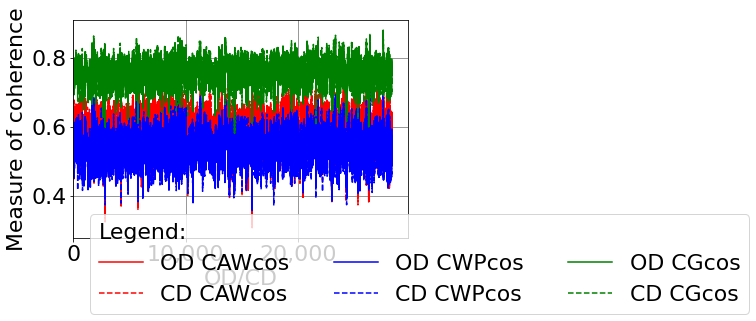

In [ ]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW, 
                   lista_perturbado_CcosCAW, 
                   lista_original_CcosCWP, 
                   lista_perturbado_CcosCWP, 
                   lista_original_CcosCG, 
                   lista_perturbado_CcosCG,
                   medida = medida)

In [ ]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCAW, lista_perturbado_CcosCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCWP, lista_perturbado_CcosCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CcosCG, lista_perturbado_CcosCG))

Diferença entre as equação CAW      : 602.3197577134695
Diferença entre as equação CWP      : 525.097912050269
Diferença entre as equação CG       : 342.57592286176487


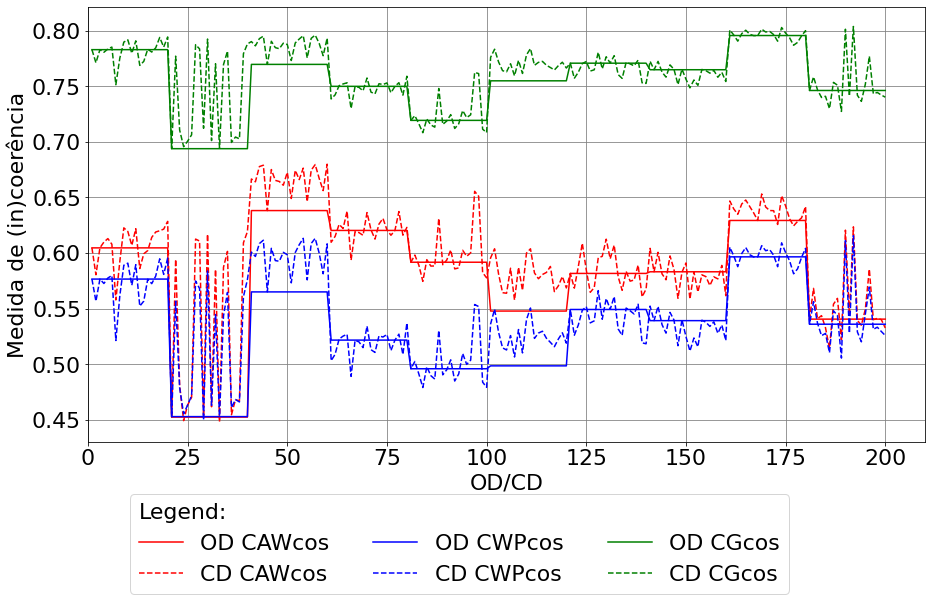

In [ ]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:200], 
                   lista_perturbado_CcosCAW[0:200], 
                   lista_original_CcosCWP[0:200], 
                   lista_perturbado_CcosCWP[0:200], 
                   lista_original_CcosCG[0:200], 
                   lista_perturbado_CcosCG[0:200],
                   medida = medida)

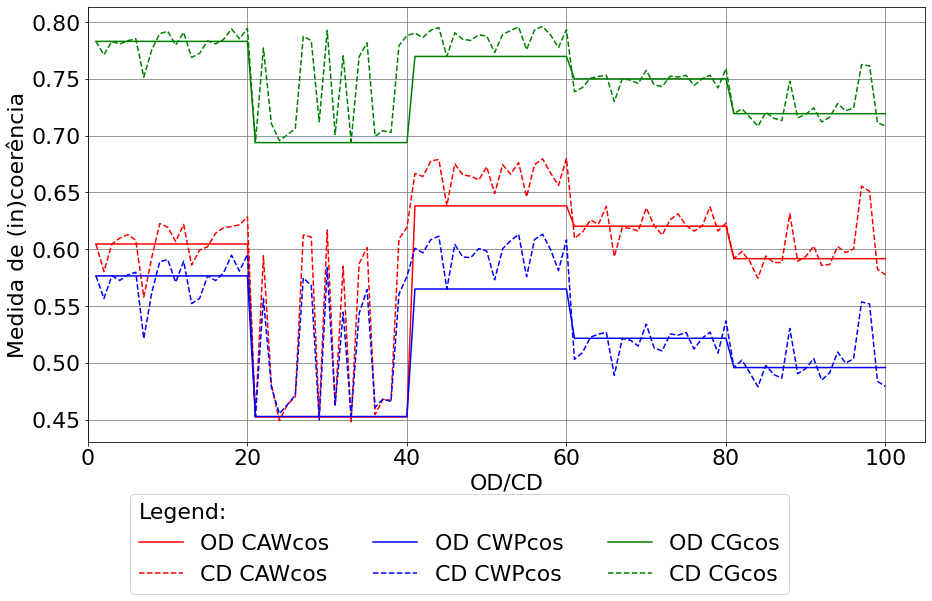

In [ ]:

graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:100], 
                   lista_perturbado_CcosCAW[0:100], 
                   lista_original_CcosCWP[0:100], 
                   lista_perturbado_CcosCWP[0:100], 
                   lista_original_CcosCG[0:100], 
                   lista_perturbado_CcosCG[0:100],
                  medida = medida)

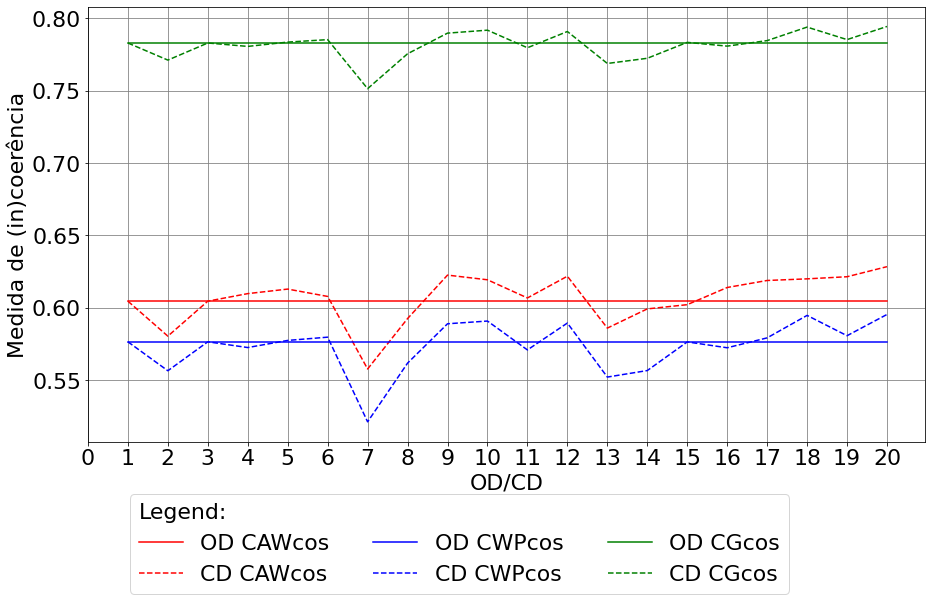

In [ ]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:20], 
                   lista_perturbado_CcosCAW[0:20], 
                   lista_original_CcosCWP[0:20], 
                   lista_perturbado_CcosCWP[0:20], 
                   lista_original_CcosCG[0:20], 
                   lista_perturbado_CcosCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

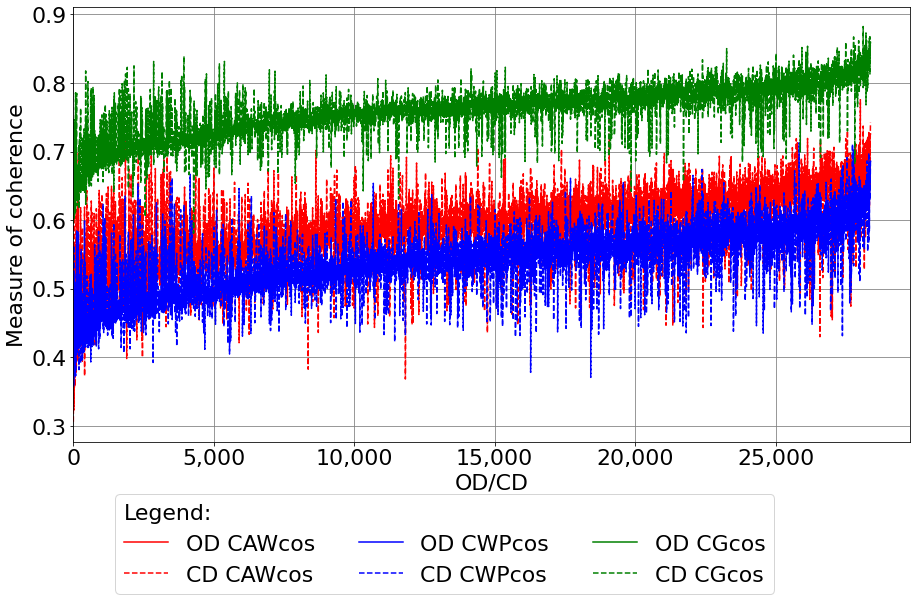

In [ ]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_ordenado_CcosCAW, 
                   lista_perturbado_ordenado_CcosCAW, 
                   lista_original_ordenado_CcosCWP, 
                   lista_perturbado_ordenado_CcosCWP, 
                   lista_original_ordenado_CcosCG, 
                   lista_perturbado_ordenado_CcosCG,
                   medida = medida)

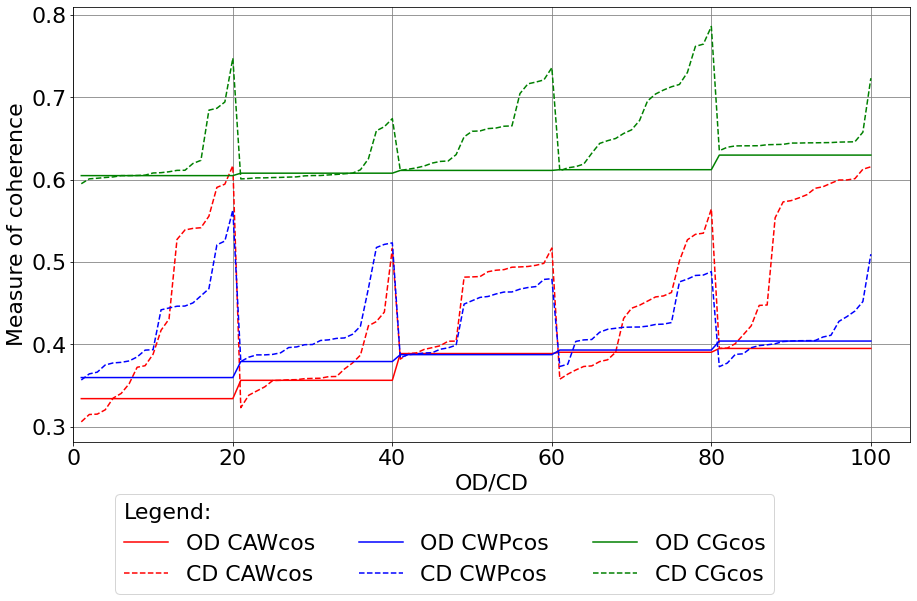

In [ ]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_ordenado_CcosCAW[0:100], 
                   lista_perturbado_ordenado_CcosCAW[0:100], 
                   lista_original_ordenado_CcosCWP[0:100], 
                   lista_perturbado_ordenado_CcosCWP[0:100], 
                   lista_original_ordenado_CcosCG[0:100], 
                   lista_perturbado_ordenado_CcosCG[0:100],
                  medida = medida)

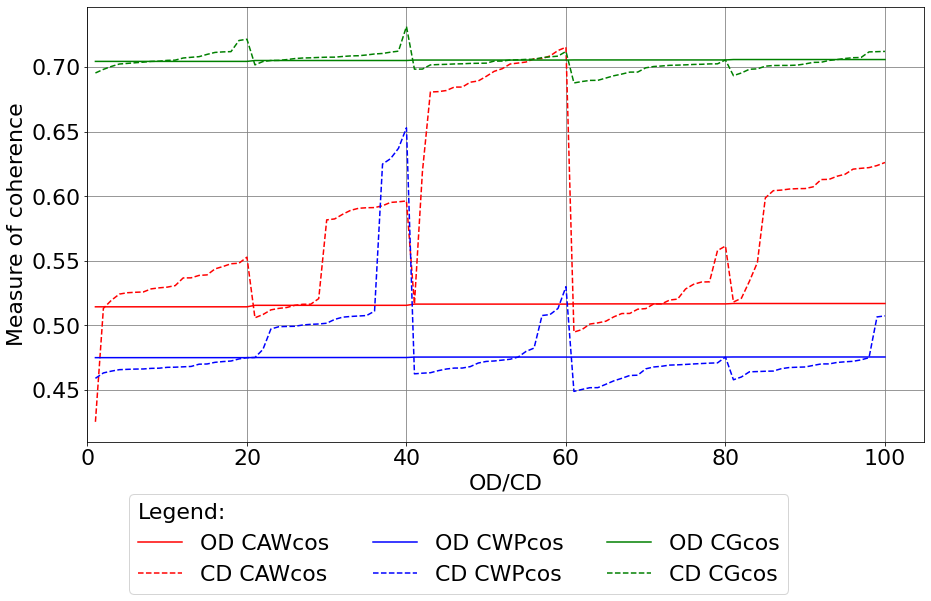

In [ ]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_ordenado_CcosCAW[2260:2360], 
                   lista_perturbado_ordenado_CcosCAW[2260:2360], 
                   lista_original_ordenado_CcosCWP[2260:2360], 
                   lista_perturbado_ordenado_CcosCWP[2260:2360], 
                   lista_original_ordenado_CcosCG[2260:2360], 
                   lista_perturbado_ordenado_CcosCG[2260:2360]
                   )

# DO central do gráfico com a maior diferença
# id = 56cdd21562d2951400fa68b2
# difabs=95.93362426757811
# Qual foi a intensidade escalada? 116
# Posição gráfico 116 * 20 = 2320 = 2260 até 2360

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

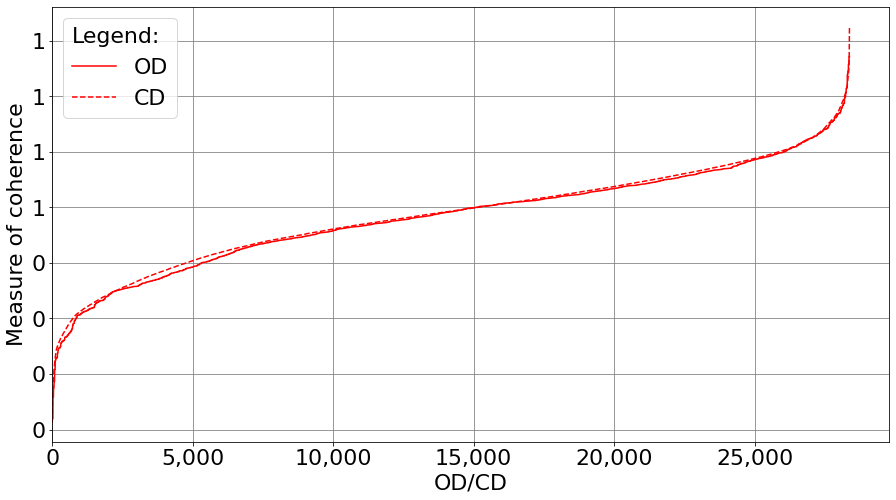

In [ ]:
graficoLinhaMedida2('Measure of coherence', 
                    lista_original_ordenado_CcosCWP, 
                    lista_perturbado_ordenado_CcosCWP,
                    medida = 'cos')

Sem ordem

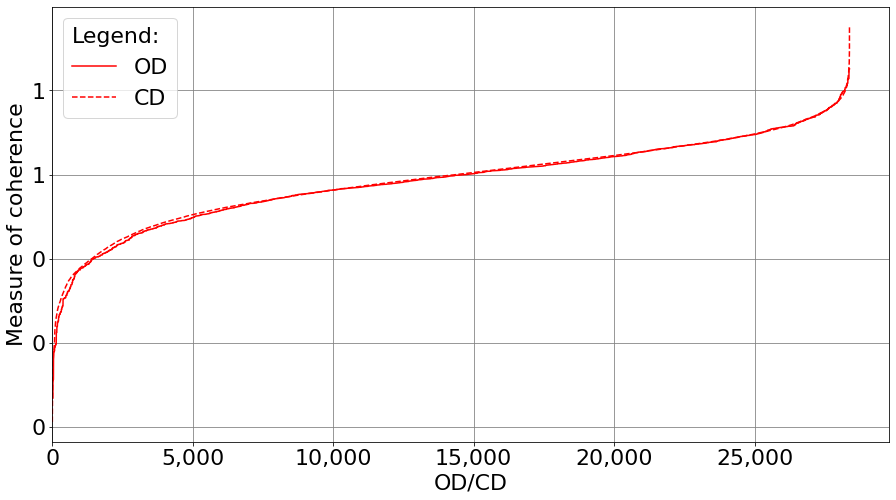

In [ ]:
graficoLinhaMedida2('Measure of coherence', 
                    lista_original_CcosCAW, 
                    lista_perturbado_CcosCAW)

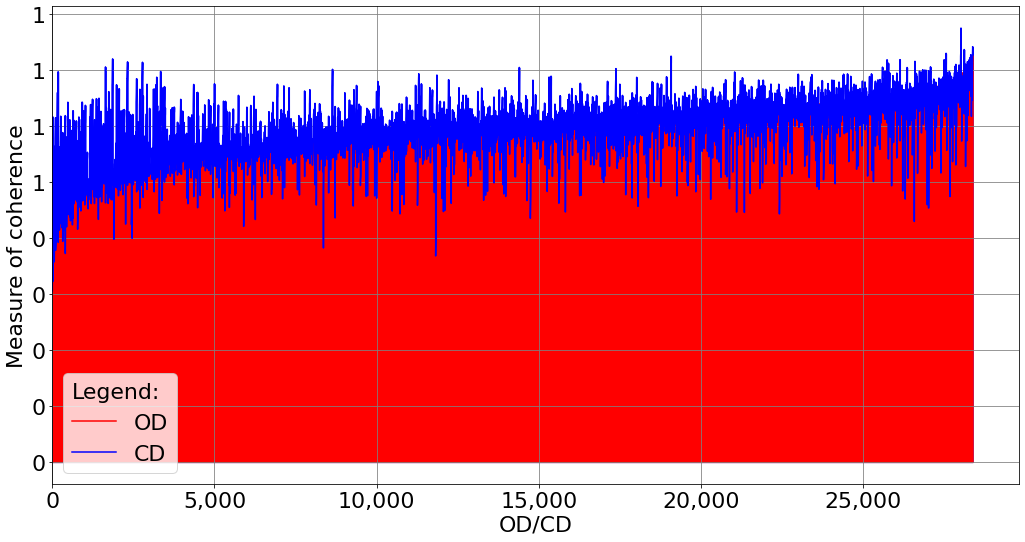

In [ ]:
graficoLinhaMedida2Preenchido('Measure of coherence', 
                              lista_original_ordenado_CcosCAW, 
                              lista_perturbado_ordenado_CcosCAW,
                              medida = 'cos')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 602.3197577134695

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57269016708984140094ca41', 0.033450218764218054, 292, 'Recent studies believe that ctenophores are the sister lineage to what?']
['570e67a80b85d914000d7e92', 0.056591783960660336, 228, 'Which market in Melbourne remained strong during the Late-2000s financial crisis and resulted in historically high property prices and rent increases?']
['5727f3a63acd2414000df0bb', 0.0642967200414698, 545, 'Despite FDA approval, how much more likely to die are patients who take bedaquiline in addition to the standard TB regimen?']
['56f81eceaef2371900625de5', 0.06498285726858999, 182, 'In what year did Tito travel to the U.S. to visit Washington D.C., amist protest by anti-communist Croat, Serb and Albanian groups?']
['56e

##### Usando CAW onde Cm(pertDO)>Cm(DO) *






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 322.2846449227479

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56d12a1317492d1400aabb13', 6.032677797174202e-05, 1050, 'What does Link discover he needs to find to return to human form?']
['5726a292dd62a815002e8b95', 8.456408977508545e-05, 1221, "Who was William Gerard Hamilton's private secretary?"]
['56d100b517492d1400aab708', 0.0001773604979882215, 1152, 'Which U.S. Billboard 200 chart topper did Kanye West produce a song for?']
['5727e36dff5b5019007d97ac', 0.0002504672322954926, 84, 'Where did Baptist missionaries take an active role in the anti-slavery movement?']
['56cff91b234ae51400d9c1be', 0.00027865833706319787, 1034, 'How do Buddhists bel

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "5728b8862ca10214002da658"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a848a6d7cf838001a46a8eb
DO: What is a key factor for the ESA?
     PRON AUX DET ADJ NOUN ADP DET PROPN PUNCT 
  1 - What is a key factor for the ESA ? [factor(>CAWcos(DO)=0,5164747126) -> factor(CAWcos(pertDO)=0,5164747126)] - NOUN/NOUN-1-1
  2 - What is a key concept for the ESA ? [factor(CAWcos(DO)=0,5164747126) -> concept(>CAWcos(pertDO)=0,6188727915)] - NOUN/NOUN-1-0
  3 - What is a key consideration for the ESA ? [factor(CAWcos(DO)=0,5164747126) -> consideration(>CAWcos(pertDO)=0,6806287766)] - NOUN/NOUN-1-0
  4 - What is a key role for the ESA ? [factor(CAWcos(DO)=0,5164747126) -> role(>CAWcos(pertDO)=0,6809275374)] - NOUN/NOUN-1-0
  5 - What is a key function for the ESA ? [factor(CAWcos(DO)=0,5164747126) -> function(>CAWcos(pertDO)=0,6817697287)] - NOUN/NOUN-1-0
  6 - What is a key word for the ESA ? [factor(CAWcos(DO)=0,5164747126) -> word(>CAWcos(pertDO)=0,6844439879)] - NOUN/NOUN-1-0
  7 - What is a key word for the ESA ? [factor(CAWcos(DO)=0,5164747126) -> word(>CAW

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a848a6d7cf838001a46a8eb
DO: What is a key factor for the ESA?
     PRON AUX DET ADJ NOUN ADP DET PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5a848a6d7cf838001a46a8eb_pert_0;What is a key issue for the ESA ?;factor;NOUN;0,5164747126;0,4832177475;0,7282423476;issue;NOUN;0,6966384873;0,6367144278;0,8216533661;0,1012361273;0;1
5a848a6d7cf838001a46a8eb_pert_1;What is a key element for the ESA ?;factor;NOUN;0,5164747126;0,4832177475;0,7282423476;element;NOUN;0,7038379461;0,6342814234;0,8204619487;0,0888641179;0;1
5a848a6d7cf838001a46a8eb_pert_2;What is a key word for the ESA ?;factor;NOUN;0,5164747126;0,4832177475;0,7282423476;word;NOUN;0,6844439879;0,6243869753;0,8149650428;0,0796592534;0;1
5a848a6d7cf838001a46a8eb_pert_3;What is a key component for the ESA ?;factor;NOUN;0,5164747126;0,4832177475;0,7282423476;component;NOUN;0,70854

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 280.0351127907188

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57114aceb654c5140001fc48', 0.00015011032422385107, 966, 'The uniflow engine is an attempt to fix an issue that arises in what cycle?']
['5ad12914645df0001a2d0ff6', 0.00018804413931716724, 1171, 'What was the geothermal capacity in 1985?']
['5acd955807355d001abf4796', 0.00021580606698989868, 399, 'What are various beers made from in Ethiopia?']
['57351665acc1501500bac3f7', 0.0003063008189201355, 1269, 'Hunting has significant financial impact in what country?']
['572657b8708984140094c31d', 0.00039353780448436737, 707, 'What are two examples of films that are marketed with speeds above th

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57114aceb654c5140001fc48
DO: The uniflow engine is an attempt to fix an issue that arises in what cycle?
     DET NOUN NOUN AUX DET NOUN PART VERB DET NOUN PRON VERB ADP DET NOUN PUNCT 
  1 - The uniflow engine is an attempt to resolve an issue that arises in what cycle ? [fix(>CAWcos(DO)=0,6181907912) -> resolve(CAWcos(pertDO)=0,6180406809)] - VERB/VERB-1-0
  2 - The uniflow engine is an attempt to fix an issue that arises in what cycle ? [fix(>CAWcos(DO)=0,6181907912) -> fix(CAWcos(pertDO)=0,6181907912)] - VERB/VERB-1-1
  3 - The uniflow engine is an attempt to correct an issue that arises in what cycle ? [fix(CAWcos(DO)=0,6181907912) -> correct(>CAWcos(pertDO)=0,6195602258)] - VERB/VERB-1-0
  4 - The uniflow engine is an attempt to remedy an issue that arises in what cycle ? [fix(CAWcos(DO)=0,6181907912) -> remedy(>CAWcos(pertDO)=0,6223468622)] - VERB/VERB-1-0
  5 - The uniflow engine is an attempt to treat an issue that arises in what cycle ? [fix(CAWcos(DO)=0,6181907912) ->

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57114aceb654c5140001fc48
DO: The uniflow engine is an attempt to fix an issue that arises in what cycle?
     DET NOUN NOUN AUX DET NOUN PART VERB DET NOUN PRON VERB ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
57114aceb654c5140001fc48_pert_0;The uniflow engine is an attempt to solve an issue that arises in what cycle ?;fix;VERB;0,6181907912;0,5792418731;0,7766640708;solve;VERB;0,6312236051;0,5858067624;0,7805810943;0,4314305186;0;1
57114aceb654c5140001fc48_pert_1;The uniflow engine is an attempt to address an issue that arises in what cycle ?;fix;VERB;0,6181907912;0,5792418731;0,7766640708;address;VERB;0,6414768656;0,5937838117;0,7853090912;0,1579746157;0;1
57114aceb654c5140001fc48_pert_2;The uniflow engine is an attempt to resolve an issue that arises in what cycle ?;fix;VERB;0,6181907912;0,5792418731;0,7766640708;resol

#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 525.097912050269

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['570e67a80b85d914000d7e92', 0.04048006681652805, 224, 'Which market in Melbourne remained strong during the Late-2000s financial crisis and resulted in historically high property prices and rent increases?']
['57269016708984140094ca41', 0.044847879671689905, 155, 'Recent studies believe that ctenophores are the sister lineage to what?']
['5727f3a63acd2414000df0bb', 0.045024268399084855, 249, 'Despite FDA approval, how much more likely to die are patients who take bedaquiline in addition to the standard TB regimen?']
['570e5b3b0dc6ce1900204f8b', 0.049740033064569866, 79, 'Do the Docklands, St. Kilda Road, and Southbank areas feature high-density or low-density forms?']
['5ad3fdac604f3c001a3ffbf5', 0.052455

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 291.2337177268418

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56f719c23d8e2e1400e37354', 4.845209743664647e-05, 570, 'A reserving party to a treaty may include a statement that attempts to do what to its legal obligations or their effects?']
['57310d2da5e9cc1400cdbbe7', 0.0001184658871756783, 1213, 'When does NCO status occur in the USAF?']
['5ad27a0dd7d075001a4295cb', 0.00015471956946644383, 1271, 'Who argued that falsificationism was defensible on logical grounds alone?']
['56e77bc037bdd419002c4018', 0.00020981298552613659, 924, 'What process does RIBA use in its accreditation system?']
['572fa080947a6a140053cae0', 0.0002626992843963727, 968,

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a848a6d7cf838001a46a8eb
DO: What is a key factor for the ESA?
     PRON AUX DET ADJ NOUN ADP DET PROPN PUNCT 
  1 - What is a key factor for the ESA ? [factor(>CWPcos(DO)=0,4832177475) -> factor(CWPcos(pertDO)=0,4832177475)] - NOUN/NOUN-1-1
  2 - What is a key concept for the ESA ? [factor(CWPcos(DO)=0,4832177475) -> concept(>CWPcos(pertDO)=0,5670620344)] - NOUN/NOUN-1-0
  3 - What is a key role for the ESA ? [factor(CWPcos(DO)=0,4832177475) -> role(>CWPcos(pertDO)=0,6089232970)] - NOUN/NOUN-1-0
  4 - What is a key consideration for the ESA ? [factor(CWPcos(DO)=0,4832177475) -> consideration(>CWPcos(pertDO)=0,6104206575)] - NOUN/NOUN-1-0
  5 - What is a key function for the ESA ? [factor(CWPcos(DO)=0,4832177475) -> function(>CWPcos(pertDO)=0,6190793158)] - NOUN/NOUN-1-0
  6 - What is a key word for the ESA ? [factor(CWPcos(DO)=0,4832177475) -> word(>CWPcos(pertDO)=0,6243869753)] - NOUN/NOUN-1-0
  7 - What is a key word for the ESA ? [factor(CWPcos(DO)=0,4832177475) -> word(>CWP

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a848a6d7cf838001a46a8eb
DO: What is a key factor for the ESA?
     PRON AUX DET ADJ NOUN ADP DET PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5a848a6d7cf838001a46a8eb_pert_0;What is a key issue for the ESA ?;factor;NOUN;0,5164747126;0,4832177475;0,7282423476;issue;NOUN;0,6966384873;0,6367144278;0,8216533661;0,1012361273;0;1
5a848a6d7cf838001a46a8eb_pert_1;What is a key element for the ESA ?;factor;NOUN;0,5164747126;0,4832177475;0,7282423476;element;NOUN;0,7038379461;0,6342814234;0,8204619487;0,0888641179;0;1
5a848a6d7cf838001a46a8eb_pert_2;What is a key word for the ESA ?;factor;NOUN;0,5164747126;0,4832177475;0,7282423476;word;NOUN;0,6844439879;0,6243869753;0,8149650428;0,0796592534;0;1
5a848a6d7cf838001a46a8eb_pert_3;What is a key component for the ESA ?;factor;NOUN;0,5164747126;0,4832177475;0,7282423476;component;NOUN;0,70854

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 233.86419432342254

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57279793dd62a815002ea15b', 1.4002037327154326e-05, 605, 'What grade do Amish children need to pass in order to be able to work for their families?']
['5ad2362ad7d075001a4287ff', 0.00012156047991340735, 497, "What university possesses Melitta Mew's library?"]
['5727cb3f2ca10214002d966d', 0.00014585527506738583, 887, 'How did Disco Eye-Cued sysems differ from LPs?']
['57324734e99e3014001e6630', 0.000243894259134958, 1188, "Is the minority leader's strategic role always consitent?"]
['56f8dcbe9e9bad19000a061c', 0.0003241896629333496, 462, "Along with the Queen Mary 2 and Queen Victoria

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57279793dd62a815002ea15b
DO: What grade do Amish children need to pass in order to be able to work for their families?
     DET NOUN AUX ADJ NOUN VERB PART VERB ADP NOUN PART AUX ADJ PART VERB ADP PRON NOUN PUNCT 
  1 - What grade do Amish children need to study in order to be able to work for their families ? [pass(>CWPcos(DO)=0,5377947636) -> study(CWPcos(pertDO)=0,5377807615)] - VERB/VERB-1-0
  2 - What grade do Amish children need to pass in order to be able to work for their families ? [pass(>CWPcos(DO)=0,5377947636) -> pass(CWPcos(pertDO)=0,5377947636)] - VERB/VERB-1-1
  3 - What grade do Amish children need to finish in order to be able to work for their families ? [pass(CWPcos(DO)=0,5377947636) -> finish(>CWPcos(pertDO)=0,5405449503)] - VERB/VERB-1-0
  4 - What grade do Amish children need to know in order to be able to work for their families ? [pass(CWPcos(DO)=0,5377947636) -> know(>CWPcos(pertDO)=0,5405940821)] - VERB/VERB-1-0
  5 - What grade do Amish children need t

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57279793dd62a815002ea15b
DO: What grade do Amish children need to pass in order to be able to work for their families?
     DET NOUN AUX ADJ NOUN VERB PART VERB ADP NOUN PART AUX ADJ PART VERB ADP PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
57279793dd62a815002ea15b_pert_0;What grade do Amish children need to learn in order to be able to work for their families ?;pass;VERB;0,6389038629;0,5377947636;0,7493936514;learn;VERB;0,6466267457;0,5414923229;0,7517114533;0,5037958026;0;1
57279793dd62a815002ea15b_pert_1;What grade do Amish children need to complete in order to be able to work for their families ?;pass;VERB;0,6389038629;0,5377947636;0,7493936514;complete;VERB;0,6464839147;0,5433103827;0,7528585760;0,0826742798;0;1
57279793dd62a815002ea15b_pert_2;What grade do Amish children need to do in order to be able to work for thei

#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 342.57592286176487

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['570e67a80b85d914000d7e92', 0.02677536349404941, 164, 'Which market in Melbourne remained strong during the Late-2000s financial crisis and resulted in historically high property prices and rent increases?']
['57269016708984140094ca41', 0.027950737004478476, 125, 'Recent studies believe that ctenophores are the sister lineage to what?']
['5727f3a63acd2414000df0bb', 0.030486604441767207, 189, 'Despite FDA approval, how much more likely to die are patients who take bedaquiline in addition to the standard TB regimen?']
['570e5b3b0dc6ce1900204f8b', 0.03444972527878587, 41, 'Do the Docklands, St. Kilda Road, and Southbank areas feature high-density or low-density forms?']
['5ad3fdac604f3c001a3ffbf5', 0.0350653

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 195.17580283832214

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a69ba4d5ce1a5001a9696c9', 0.0001197716464167442, 535, 'In which number report to the Council did the Prosecutor concede that crimes had been committed but evidence for prosecution was sufficient?']
['572abfa0be1ee31400cb820f', 0.00014165639877328218, 1174, 'Which four classes made up the ancient -Chamorro society?']
['572fa080947a6a140053cae0', 0.00014972686767589227, 832, 'The United States and many Western countries began what policy to fight communism?']
['5726d83d708984140094d335', 0.00025831907987594604, 180, 'States can grant their people broader rights than those granted in wh

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56d370aa59d6e414001463c2
DO: Where was Christina Christian at when she was eliminated from the show?
     SCONJ AUX PROPN PROPN ADP SCONJ PRON AUX VERB ADP DET NOUN PUNCT 
  1 - Where was Christina Christian at when she was fired from the show ? [eliminated(CGcos(DO)=0,6307118624) -> fired(>CGcos(pertDO)=0,6527979099)] - VERB/VERB-1-0
  2 - Where was Christina Christian at when she was sacked from the show ? [eliminated(CGcos(DO)=0,6307118624) -> sacked(>CGcos(pertDO)=0,6709061348)] - VERB/VERB-1-0
  3 - Where was Christina Christian at when she was cut from the show ? [eliminated(CGcos(DO)=0,6307118624) -> cut(>CGcos(pertDO)=0,7031941545)] - VERB/VERB-1-0
  4 - Where was Christina Christian at when she was kidnapped from the show ? [eliminated(CGcos(DO)=0,6307118624) -> kidnapped(>CGcos(pertDO)=0,7132053983)] - VERB/VERB-1-0
  5 - Where was Christina Christian at when she was ejected from the show ? [eliminated(CGcos(DO)=0,6307118624) -> ejected(>CGcos(pertDO)=0,7152177044)] - 

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56d370aa59d6e414001463c2
DO: Where was Christina Christian at when she was eliminated from the show?
     SCONJ AUX PROPN PROPN ADP SCONJ PRON AUX VERB ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
56d370aa59d6e414001463c2_pert_0;Where was Christina Christian at when she was fired from the show ?;eliminated;VERB;0,4123798025;0,4120901627;0,6307118624;fired;VERB;0,4433606857;0,4436172465;0,6527979099;0,3161287010;0;1
56d370aa59d6e414001463c2_pert_1;Where was Christina Christian at when she was absent from the show ?;eliminated;VERB;0,4123798025;0,4120901627;0,6307118624;absent;ADJ;0,5416592859;0,5062057113;0,7269547410;0,0955262110;0;0
56d370aa59d6e414001463c2_pert_2;Where was Christina Christian at when she was gone from the show ?;eliminated;VERB;0,4123798025;0,4120901627;0,6307118624;gone;VERB;0,6354068418;0,5700554332;0

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 147.4001200234406

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57279793dd62a815002ea15b', 2.3995575151869453e-05, 458, 'What grade do Amish children need to pass in order to be able to work for their families?']
['5709aacc200fba1400368242', 3.424882888791725e-05, 1360, 'Whan was NCAZ founded?']
['570c23e1ec8fbc190045bc80', 3.834126087332024e-05, 172, 'Did the FBI reassign agents from counter-intelligence to violent crime?']
['57324734e99e3014001e6630', 7.524490356436431e-05, 1110, "Is the minority leader's strategic role always consitent?"]
['5a8c8e7dfd22b3001a8d8ad5', 0.00020927190780639648, 490, 'What is no longer considered database storage?']


Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57279793dd62a815002ea15b
DO: What grade do Amish children need to pass in order to be able to work for their families?
     DET NOUN AUX ADJ NOUN VERB PART VERB ADP NOUN PART AUX ADJ PART VERB ADP PRON NOUN PUNCT 
  1 - What grade do Amish children need to study in order to be able to work for their families ? [pass(>CGcos(DO)=0,7493936514) -> study(CGcos(pertDO)=0,7493696558)] - VERB/VERB-1-0
  2 - What grade do Amish children need to pass in order to be able to work for their families ? [pass(>CGcos(DO)=0,7493936514) -> pass(CGcos(pertDO)=0,7493936514)] - VERB/VERB-1-1
  3 - What grade do Amish children need to finish in order to be able to work for their families ? [pass(CGcos(DO)=0,7493936514) -> finish(>CGcos(pertDO)=0,7511184090)] - VERB/VERB-1-0
  4 - What grade do Amish children need to know in order to be able to work for their families ? [pass(CGcos(DO)=0,7493936514) -> know(>CGcos(pertDO)=0,7511522707)] - VERB/VERB-1-0
  5 - What grade do Amish children need to meet i

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57279793dd62a815002ea15b
DO: What grade do Amish children need to pass in order to be able to work for their families?
     DET NOUN AUX ADJ NOUN VERB PART VERB ADP NOUN PART AUX ADJ PART VERB ADP PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
57279793dd62a815002ea15b_pert_0;What grade do Amish children need to learn in order to be able to work for their families ?;pass;VERB;0,6389038629;0,5377947636;0,7493936514;learn;VERB;0,6466267457;0,5414923229;0,7517114533;0,5037958026;0;1
57279793dd62a815002ea15b_pert_1;What grade do Amish children need to complete in order to be able to work for their families ?;pass;VERB;0,6389038629;0,5377947636;0,7493936514;complete;VERB;0,6464839147;0,5433103827;0,7528585760;0,0826742798;0;1
57279793dd62a815002ea15b_pert_2;What grade do Amish children need to do in order to be able to work for thei

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 147.4001200234406

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57269016708984140094ca41', 0.005185641348361969, 292, 'Recent studies believe that ctenophores are the sister lineage to what?']
['570e67a80b85d914000d7e92', 0.007392693133581263, 228, 'Which market in Melbourne remained strong during the Late-2000s financial crisis and resulted in historically high property prices and rent increases?']
['57098302ed30961900e84251', 0.008249509632587526, 152, 'In what classification is a person who gives up their exclusive sense of self and defines him or herself only in terms of social engagement?']
['5727f3a63acd2414000df0bb', 0.009063118560747596, 545, 'Despite FDA approval, how much more likely to die are patients who

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 147.4001200234406

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56d12a1317492d1400aabb13', 6.032677797174202e-05, 1050, 'What does Link discover he needs to find to return to human form?']
['5726a292dd62a815002e8b95', 8.456408977508545e-05, 1221, "Who was William Gerard Hamilton's private secretary?"]
['56d100b517492d1400aab708', 0.0001773604979882215, 1152, 'Which U.S. Billboard 200 chart topper did Kanye West produce a song for?']
['5727e36dff5b5019007d97ac', 0.0002504672322954926, 84, 'Where did Baptist missionaries take an active role in the anti-slavery movement?']
['56cff91b234ae51400d9c1be', 0.00027865833706319787, 1034, 'How do Buddhists believe their

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57269446dd62a815002e8a26
DO: What's the name of the cave system
     PRON AUX DET NOUN ADP DET NOUN NOUN 
  1 - What 's the name of the cave | [system(>CAWcos(DO)=0,3341077135) -> |(CAWcos(pertDO)=0,3059671600)] - NOUN/NOUN-1-0
  2 - What 's the name of the cave / [system(>CAWcos(DO)=0,3341077135) -> /(CAWcos(pertDO)=0,3148739216)] - NOUN/PUNCT-0-0
  3 - What 's the name of the cave the [system(>CAWcos(DO)=0,3341077135) -> the(CAWcos(pertDO)=0,3152996517)] - NOUN/PRON-0-0
  4 - What 's the name of the cave ? [system(>CAWcos(DO)=0,3341077135) -> ?(CAWcos(pertDO)=0,3205529583)] - NOUN/PUNCT-0-0
  5 - What 's the name of the cave ' [system(CAWcos(DO)=0,3341077135) -> '(>CAWcos(pertDO)=0,3347978102)] - NOUN/PUNCT-0-0
  6 - What 's the name of the cave here [system(CAWcos(DO)=0,3341077135) -> here(>CAWcos(pertDO)=0,3403979838)] - NOUN/ADV-0-0
  7 - What 's the name of the cave " [system(CAWcos(DO)=0,3341077135) -> "(>CAWcos(pertDO)=0,3521702066)] - NOUN/PUNCT-0-0
  8 - What 's the na

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57269446dd62a815002e8a26
DO: What's the name of the cave system
     PRON AUX DET NOUN ADP DET NOUN NOUN 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
57269446dd62a815002e8a26_pert_0;What 's the name of the cave ?;system;NOUN;0,3341077135;0,3596958646;0,6119699962;?;PUNCT;0,3205529583;0,3662407798;0,6438799649;0,9959736466;0;0
57269446dd62a815002e8a26_pert_1;What 's the name of the cave .;system;NOUN;0,3341077135;0,3596958646;0,6119699962;.;PUNCT;0,4171282129;0,4462640932;0,7154254187;0,0031176342;0;0
57269446dd62a815002e8a26_pert_2;What 's the name of the cave !;system;NOUN;0,3341077135;0,3596958646;0,6119699962;!;PUNCT;0,4307020312;0,4588720120;0,7037955318;0,0005410371;0;0
57269446dd62a815002e8a26_pert_3;What 's the name of the cave ;;system;NOUN;0,3341077135;0,3596958646;0,6119699962;;;PUNCT;0,5943970893;0,5207317402;0,7616230026;0,00027

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 147.4001200234406

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57114aceb654c5140001fc48', 0.00015011032422385107, 966, 'The uniflow engine is an attempt to fix an issue that arises in what cycle?']
['5ad12914645df0001a2d0ff6', 0.00018804413931716724, 1171, 'What was the geothermal capacity in 1985?']
['5acd955807355d001abf4796', 0.00021580606698989868, 399, 'What are various beers made from in Ethiopia?']
['57351665acc1501500bac3f7', 0.0003063008189201355, 1269, 'Hunting has significant financial impact in what country?']
['572657b8708984140094c31d', 0.00039353780448436737, 707, 'What are two examples of films that are marketed with speeds above their true I

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5acd1e2007355d001abf35b3
DO: What occurs in sound clusters?
     PRON VERB ADP ADJ NOUN PUNCT 
  1 - What results in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> results(CAWcos(pertDO)=0,4300318271)] - VERB/VERB-1-0
  2 - What differences in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> differences(CAWcos(pertDO)=0,4307086706)] - VERB/NOUN-0-0
  3 - What holds in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> holds(CAWcos(pertDO)=0,6248182714)] - VERB/VERB-1-0
  4 - What was in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> was(CAWcos(pertDO)=0,6399084210)] - VERB/AUX-0-0
  5 - What works in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> works(CAWcos(pertDO)=0,6478485584)] - VERB/VERB-1-0
  6 - What lies in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> lies(CAWcos(pertDO)=0,6481501162)] - VERB/VERB-1-0
  7 - What is in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> is(CAWcos(pertDO)=0,6523814082)] - VERB/AUX-0-0
  8 - What are

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5acd1e2007355d001abf35b3
DO: What occurs in sound clusters?
     PRON VERB ADP ADJ NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5acd1e2007355d001abf35b3_pert_0;What happens in sound clusters ?;occurs;VERB;0,6621826530;0,6181822201;0,8257013063;happens;VERB;0,6897368312;0,6516291380;0,8423970044;0,4972650707;0;1
5acd1e2007355d001abf35b3_pert_1;What is in sound clusters ?;occurs;VERB;0,6621826530;0,6181822201;0,8257013063;is;AUX;0,6523814082;0,6281093081;0,8306643267;0,1877356023;0;0
5acd1e2007355d001abf35b3_pert_2;What happened in sound clusters ?;occurs;VERB;0,6621826530;0,6181822201;0,8257013063;happened;VERB;0,7162981987;0,6811639150;0,8568774362;0,0874795169;0;1
5acd1e2007355d001abf35b3_pert_3;What occurs in sound clusters ?;occurs;VERB;0,6621826530;0,6181822201;0,8257013063;occurs;VERB;0,6621826530;0,6181822201;0,8257013063;0

#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 147.4001200234406

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5727f3a63acd2414000df0bb', 0.005245651081646208, 249, 'Despite FDA approval, how much more likely to die are patients who take bedaquiline in addition to the standard TB regimen?']
['570e67a80b85d914000d7e92', 0.006037910779317313, 224, 'Which market in Melbourne remained strong during the Late-2000s financial crisis and resulted in historically high property prices and rent increases?']
['5ad3fdac604f3c001a3ffbf5', 0.006799863834007103, 229, 'What state\'s law says that death sentences must not take place in an "enclosure"?']
['57269016708984140094ca41', 0.007649459283460336, 155, 'Recent studies believe that ctenophores are the sister lineage to what?'

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 147.4001200234406

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56f719c23d8e2e1400e37354', 4.845209743664647e-05, 570, 'A reserving party to a treaty may include a statement that attempts to do what to its legal obligations or their effects?']
['5ad27a0dd7d075001a4295cb', 8.945194157694569e-05, 1271, 'Who argued that falsificationism was defensible on logical grounds alone?']
['57310d2da5e9cc1400cdbbe7', 0.0001184658871756783, 1213, 'When does NCO status occur in the USAF?']
['572fa080947a6a140053cae0', 0.0001666889740871147, 968, 'The United States and many Western countries began what policy to fight communism?']
['56e77bc037bdd419002c4018', 0.0002098129855

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57269446dd62a815002e8a26
DO: What's the name of the cave system
     PRON AUX DET NOUN ADP DET NOUN NOUN 
  1 - What 's the name of the cave | [system(>CAWcos(DO)=0,3341077135) -> |(CAWcos(pertDO)=0,3059671600)] - NOUN/NOUN-1-0
  2 - What 's the name of the cave / [system(>CAWcos(DO)=0,3341077135) -> /(CAWcos(pertDO)=0,3148739216)] - NOUN/PUNCT-0-0
  3 - What 's the name of the cave the [system(>CAWcos(DO)=0,3341077135) -> the(CAWcos(pertDO)=0,3152996517)] - NOUN/PRON-0-0
  4 - What 's the name of the cave ? [system(>CAWcos(DO)=0,3341077135) -> ?(CAWcos(pertDO)=0,3205529583)] - NOUN/PUNCT-0-0
  5 - What 's the name of the cave ' [system(CAWcos(DO)=0,3341077135) -> '(>CAWcos(pertDO)=0,3347978102)] - NOUN/PUNCT-0-0
  6 - What 's the name of the cave here [system(CAWcos(DO)=0,3341077135) -> here(>CAWcos(pertDO)=0,3403979838)] - NOUN/ADV-0-0
  7 - What 's the name of the cave " [system(CAWcos(DO)=0,3341077135) -> "(>CAWcos(pertDO)=0,3521702066)] - NOUN/PUNCT-0-0
  8 - What 's the na

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57269446dd62a815002e8a26
DO: What's the name of the cave system
     PRON AUX DET NOUN ADP DET NOUN NOUN 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
57269446dd62a815002e8a26_pert_0;What 's the name of the cave ?;system;NOUN;0,3341077135;0,3596958646;0,6119699962;?;PUNCT;0,3205529583;0,3662407798;0,6438799649;0,9959736466;0;0
57269446dd62a815002e8a26_pert_1;What 's the name of the cave .;system;NOUN;0,3341077135;0,3596958646;0,6119699962;.;PUNCT;0,4171282129;0,4462640932;0,7154254187;0,0031176342;0;0
57269446dd62a815002e8a26_pert_2;What 's the name of the cave !;system;NOUN;0,3341077135;0,3596958646;0,6119699962;!;PUNCT;0,4307020312;0,4588720120;0,7037955318;0,0005410371;0;0
57269446dd62a815002e8a26_pert_3;What 's the name of the cave ;;system;NOUN;0,3341077135;0,3596958646;0,6119699962;;;PUNCT;0,5943970893;0,5207317402;0,7616230026;0,00027

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 147.4001200234406

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57279793dd62a815002ea15b', 1.4002037327154326e-05, 605, 'What grade do Amish children need to pass in order to be able to work for their families?']
['5ad2362ad7d075001a4287ff', 0.00012156047991340735, 497, "What university possesses Melitta Mew's library?"]
['5727cb3f2ca10214002d966d', 0.00014585527506738583, 887, 'How did Disco Eye-Cued sysems differ from LPs?']
['57324734e99e3014001e6630', 0.000243894259134958, 1188, "Is the minority leader's strategic role always consitent?"]
['56f8dcbe9e9bad19000a061c', 0.0003241896629333496, 462, "Along with the Queen Mary 2 and Queen Victoria, which third 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5726b763708984140094ced3
DO: What was notable about the discovered vitamin A?
     PRON AUX ADJ ADP DET VERB NOUN NOUN PUNCT 
  1 - What was notable about the name vitamin A ? [discovered(>CAWcos(DO)=0,6122844070) -> name(CAWcos(pertDO)=0,4719858742)] - VERB/NOUN-0-0
  2 - What was notable about the mysterious vitamin A ? [discovered(>CAWcos(DO)=0,6122844070) -> mysterious(CAWcos(pertDO)=0,5891764052)] - VERB/ADJ-0-0
  3 - What was notable about the missing vitamin A ? [discovered(>CAWcos(DO)=0,6122844070) -> missing(CAWcos(pertDO)=0,5942716561)] - VERB/VERB-1-0
  4 - What was notable about the unusual vitamin A ? [discovered(>CAWcos(DO)=0,6122844070) -> unusual(CAWcos(pertDO)=0,5998053998)] - VERB/ADJ-0-0
  5 - What was notable about the other vitamin A ? [discovered(>CAWcos(DO)=0,6122844070) -> other(CAWcos(pertDO)=0,6003922522)] - VERB/ADJ-0-0
  6 - What was notable about the little vitamin A ? [discovered(>CAWcos(DO)=0,6122844070) -> little(CAWcos(pertDO)=0,6059633642)] - VE

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5726b763708984140094ced3
DO: What was notable about the discovered vitamin A?
     PRON AUX ADJ ADP DET VERB NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5726b763708984140094ced3_pert_0;What was notable about the missing vitamin A ?;discovered;VERB;0,6122844070;0,5609204844;0,7808111906;missing;VERB;0,5942716561;0,5527524749;0,7761415707;0,1703941375;0;1
5726b763708984140094ced3_pert_1;What was notable about the extra vitamin A ?;discovered;VERB;0,6122844070;0,5609204844;0,7808111906;extra;ADJ;0,6181643791;0,5627838994;0,7818646895;0,1261513829;0;0
5726b763708984140094ced3_pert_2;What was notable about the added vitamin A ?;discovered;VERB;0,6122844070;0,5609204844;0,7808111906;added;VERB;0,6243619435;0,5663942132;0,7839143806;0,0326075554;0;1
5726b763708984140094ced3_pert_3;What was notable about the new vitamin A ?;discove

#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 147.4001200234406

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5727f3a63acd2414000df0bb', 0.0035626771657363276, 189, 'Despite FDA approval, how much more likely to die are patients who take bedaquiline in addition to the standard TB regimen?']
['570e67a80b85d914000d7e92', 0.004122889854691225, 164, 'Which market in Melbourne remained strong during the Late-2000s financial crisis and resulted in historically high property prices and rent increases?']
['5ad3fdac604f3c001a3ffbf5', 0.004508272641234878, 194, 'What state\'s law says that death sentences must not take place in an "enclosure"?']
['56d65e391c850414009470c7', 0.00474636895315983, 882, 'Who was supposed to inspect building to see if they met national standards

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 147.4001200234406

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['572fa080947a6a140053cae0', 9.925450597492169e-05, 832, 'The United States and many Western countries began what policy to fight communism?']
['572abfa0be1ee31400cb820f', 0.00011181235313417748, 1174, 'Which four classes made up the ancient -Chamorro society?']
['5a69ba4d5ce1a5001a9696c9', 0.0001197716464167442, 535, 'In which number report to the Council did the Prosecutor concede that crimes had been committed but evidence for prosecution was sufficient?']
['5ad27a0dd7d075001a4295cb', 0.00024371255527844138, 1102, 'Who argued that falsificationism was defensible on logical grounds alone?']
['5726d

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57269446dd62a815002e8a26
DO: What's the name of the cave system
     PRON AUX DET NOUN ADP DET NOUN NOUN 
  1 - What 's the name of the cave | [system(>CAWcos(DO)=0,3341077135) -> |(CAWcos(pertDO)=0,3059671600)] - NOUN/NOUN-1-0
  2 - What 's the name of the cave / [system(>CAWcos(DO)=0,3341077135) -> /(CAWcos(pertDO)=0,3148739216)] - NOUN/PUNCT-0-0
  3 - What 's the name of the cave the [system(>CAWcos(DO)=0,3341077135) -> the(CAWcos(pertDO)=0,3152996517)] - NOUN/PRON-0-0
  4 - What 's the name of the cave ? [system(>CAWcos(DO)=0,3341077135) -> ?(CAWcos(pertDO)=0,3205529583)] - NOUN/PUNCT-0-0
  5 - What 's the name of the cave ' [system(CAWcos(DO)=0,3341077135) -> '(>CAWcos(pertDO)=0,3347978102)] - NOUN/PUNCT-0-0
  6 - What 's the name of the cave here [system(CAWcos(DO)=0,3341077135) -> here(>CAWcos(pertDO)=0,3403979838)] - NOUN/ADV-0-0
  7 - What 's the name of the cave " [system(CAWcos(DO)=0,3341077135) -> "(>CAWcos(pertDO)=0,3521702066)] - NOUN/PUNCT-0-0
  8 - What 's the na

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57269446dd62a815002e8a26
DO: What's the name of the cave system
     PRON AUX DET NOUN ADP DET NOUN NOUN 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
57269446dd62a815002e8a26_pert_0;What 's the name of the cave ?;system;NOUN;0,3341077135;0,3596958646;0,6119699962;?;PUNCT;0,3205529583;0,3662407798;0,6438799649;0,9959736466;0;0
57269446dd62a815002e8a26_pert_1;What 's the name of the cave .;system;NOUN;0,3341077135;0,3596958646;0,6119699962;.;PUNCT;0,4171282129;0,4462640932;0,7154254187;0,0031176342;0;0
57269446dd62a815002e8a26_pert_2;What 's the name of the cave !;system;NOUN;0,3341077135;0,3596958646;0,6119699962;!;PUNCT;0,4307020312;0,4588720120;0,7037955318;0,0005410371;0;0
57269446dd62a815002e8a26_pert_3;What 's the name of the cave ;;system;NOUN;0,3341077135;0,3596958646;0,6119699962;;;PUNCT;0,5943970893;0,5207317402;0,7616230026;0,00027

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 147.4001200234406

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57279793dd62a815002ea15b', 2.3995575151869453e-05, 458, 'What grade do Amish children need to pass in order to be able to work for their families?']
['5709aacc200fba1400368242', 3.424882888791725e-05, 1360, 'Whan was NCAZ founded?']
['570c23e1ec8fbc190045bc80', 3.834126087332024e-05, 172, 'Did the FBI reassign agents from counter-intelligence to violent crime?']
['57324734e99e3014001e6630', 7.524490356436431e-05, 1110, "Is the minority leader's strategic role always consitent?"]
['5a8c8e7dfd22b3001a8d8ad5', 0.00020927190780639648, 490, 'What is no longer considered database storage?']

Os 5 últimos

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5acd1e2007355d001abf35b3
DO: What occurs in sound clusters?
     PRON VERB ADP ADJ NOUN PUNCT 
  1 - What results in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> results(CAWcos(pertDO)=0,4300318271)] - VERB/VERB-1-0
  2 - What differences in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> differences(CAWcos(pertDO)=0,4307086706)] - VERB/NOUN-0-0
  3 - What holds in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> holds(CAWcos(pertDO)=0,6248182714)] - VERB/VERB-1-0
  4 - What was in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> was(CAWcos(pertDO)=0,6399084210)] - VERB/AUX-0-0
  5 - What works in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> works(CAWcos(pertDO)=0,6478485584)] - VERB/VERB-1-0
  6 - What lies in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> lies(CAWcos(pertDO)=0,6481501162)] - VERB/VERB-1-0
  7 - What is in sound clusters ? [occurs(>CAWcos(DO)=0,6621826530) -> is(CAWcos(pertDO)=0,6523814082)] - VERB/AUX-0-0
  8 - What are

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5acd1e2007355d001abf35b3
DO: What occurs in sound clusters?
     PRON VERB ADP ADJ NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5acd1e2007355d001abf35b3_pert_0;What happens in sound clusters ?;occurs;VERB;0,6621826530;0,6181822201;0,8257013063;happens;VERB;0,6897368312;0,6516291380;0,8423970044;0,4972650707;0;1
5acd1e2007355d001abf35b3_pert_1;What is in sound clusters ?;occurs;VERB;0,6621826530;0,6181822201;0,8257013063;is;AUX;0,6523814082;0,6281093081;0,8306643267;0,1877356023;0;0
5acd1e2007355d001abf35b3_pert_2;What happened in sound clusters ?;occurs;VERB;0,6621826530;0,6181822201;0,8257013063;happened;VERB;0,7162981987;0,6811639150;0,8568774362;0,0874795169;0;1
5acd1e2007355d001abf35b3_pert_3;What occurs in sound clusters ?;occurs;VERB;0,6621826530;0,6181822201;0,8257013063;occurs;VERB;0,6621826530;0,6181822201;0,8257013063;0

## 3.6  Avaliando o cálculo da incoerência com todas as equações e com a medida de distância euclidiana(euc)






In [ ]:
medida = 'euc'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 14703 de 28380
Percentual de documentos coerentes em relação ao total: 51.807610993657505
Acertos Perturbado : 13677 de 28380
Percentual de documentos incoerentes em relação ao total: 48.192389006342495


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 14093 de 28380
Percentual de documentos coerentes em relação ao total: 49.65821000704722
Acertos Perturbado : 14287 de 28380
Percentual de documentos incoerentes em relação ao total: 50.341789992952776


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 14041 de 28380
Percentual de documentos coerentes em relação ao total: 49.47498238195912
Acertos Perturbado : 14339 de 28380
Percentual de documentos incoerentes em relação ao total: 50.52501761804087


### Gráficos

#### Gráfico de linha das medida de coerência Ceuc dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





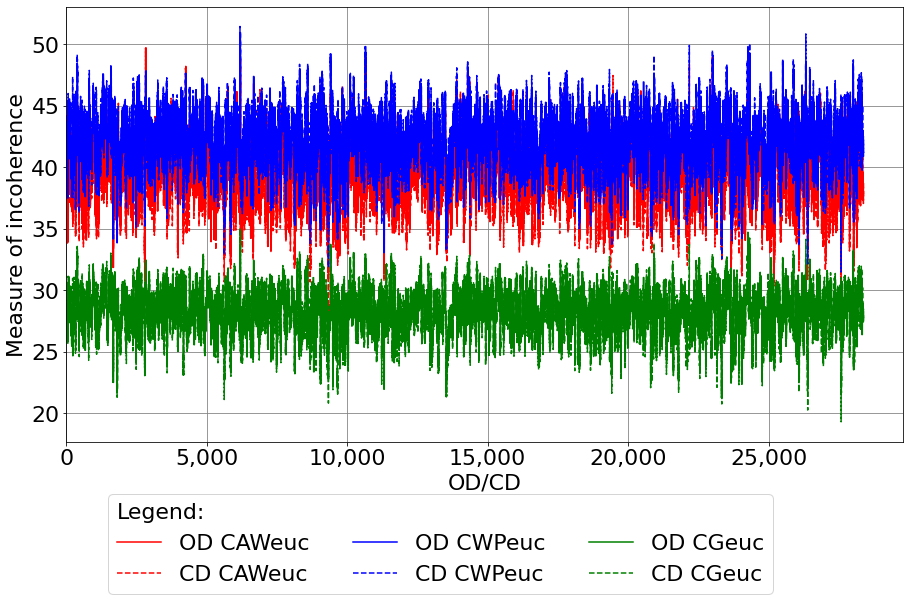

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CeucCAW, 
                   lista_perturbado_CeucCAW, 
                   lista_original_CeucCWP, 
                   lista_perturbado_CeucCWP, 
                   lista_original_CeucCG, 
                   lista_perturbado_CeucCG,
                   medida = medida)

In [ ]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 31255.53427825901
Diferença absoluta entre as medidas equação CWP : 26976.875244646224
Diferença absoluta entre as medidas equação CG  : 17889.525444447445


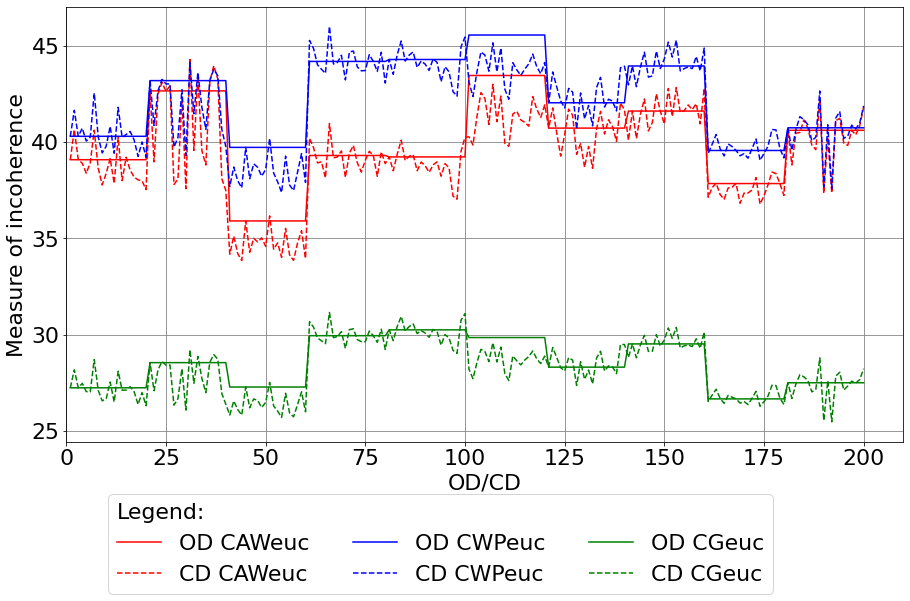

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CeucCAW[0:200], 
                   lista_perturbado_CeucCAW[0:200], 
                   lista_original_CeucCWP[0:200], 
                   lista_perturbado_CeucCWP[0:200], 
                   lista_original_CeucCG[0:200], 
                   lista_perturbado_CeucCG[0:200],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

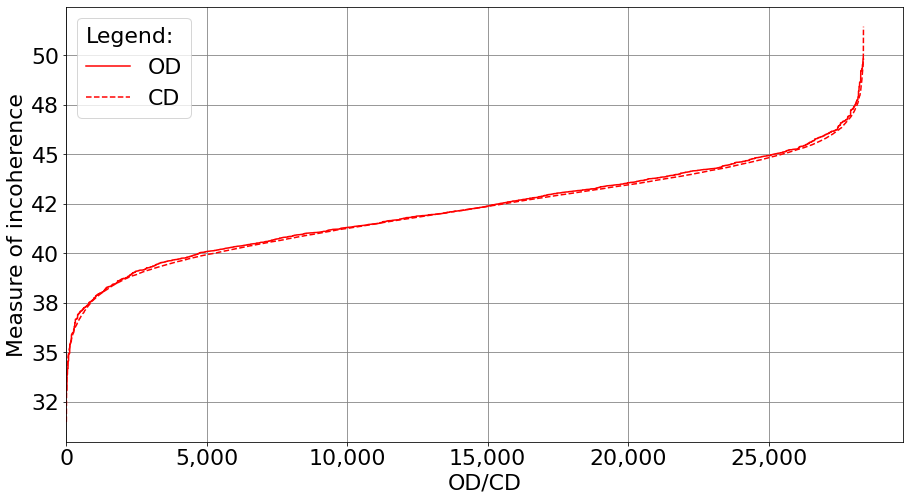

In [ ]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CeucCWP, 
                    lista_perturbado_CeucCWP,
                    'r',
                    medida = medida)

Sem ordem

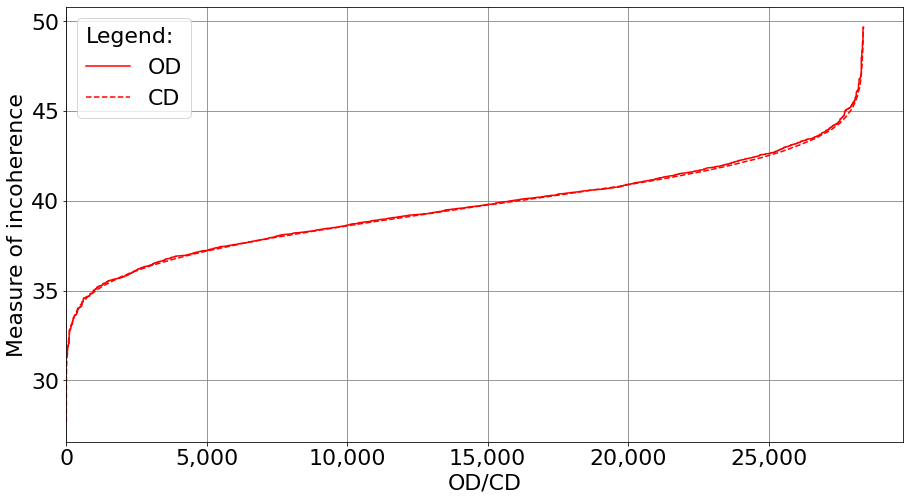

In [ ]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CeucCAW, 
                    lista_perturbado_CeucCAW,
                    'r',
                    medida = 'euc')

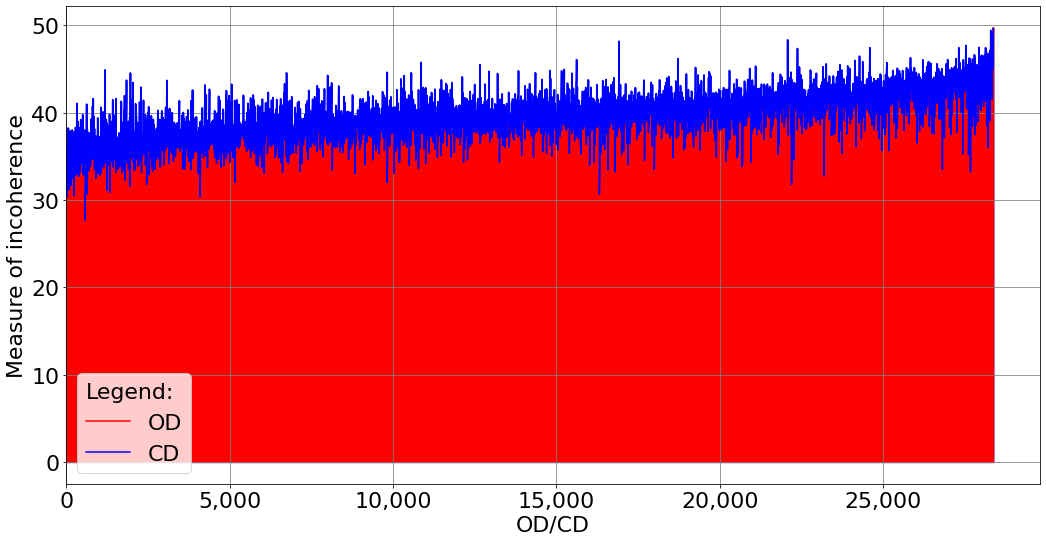

In [ ]:
graficoLinhaMedida2Preenchido('Measure of incoherence', 
                              lista_original_ordenado_CeucCAW, 
                              lista_perturbado_ordenado_CeucCAW,
                              medida = 'euc')

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

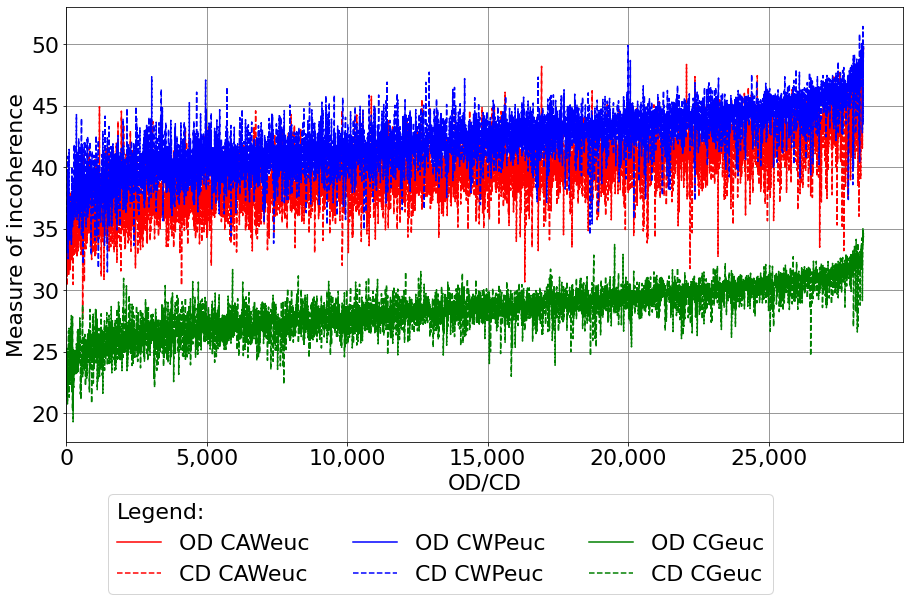

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW, 
                   lista_perturbado_ordenado_CeucCAW, 
                   lista_original_ordenado_CeucCWP, 
                   lista_perturbado_ordenado_CeucCWP, 
                   lista_original_ordenado_CeucCG, 
                   lista_perturbado_ordenado_CeucCG,
                   medida = medida)

In [ ]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 31255.53427825901
Diferença absoluta entre as medidas equação CWP : 26976.875244646224
Diferença absoluta entre as medidas equação CG  : 17889.525444447445


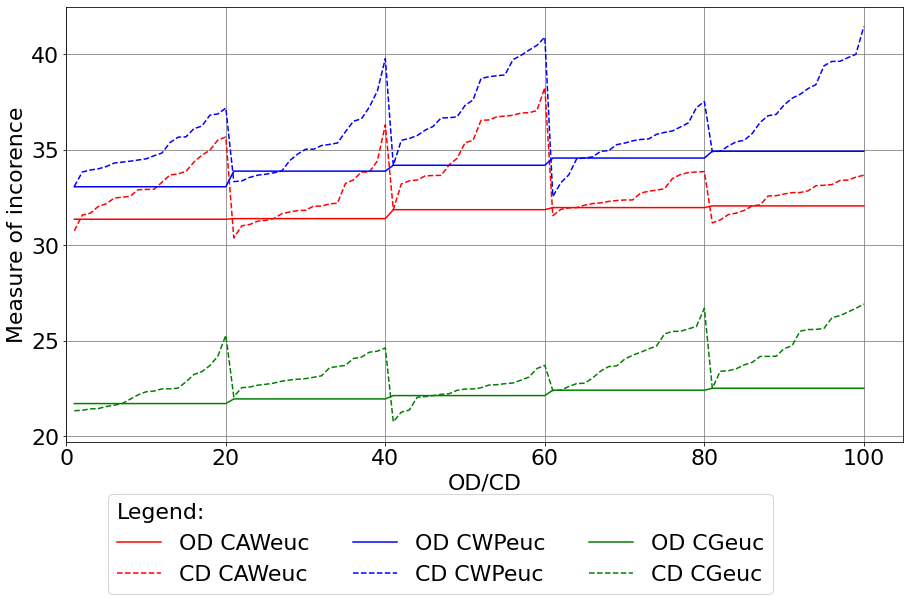

In [ ]:
graficoLinhaMedida('Measure of incorence', 
                   lista_original_ordenado_CeucCAW[0:100], 
                   lista_perturbado_ordenado_CeucCAW[0:100], 
                   lista_original_ordenado_CeucCWP[0:100], 
                   lista_perturbado_ordenado_CeucCWP[0:100], 
                   lista_original_ordenado_CeucCG[0:100], 
                   lista_perturbado_ordenado_CeucCG[0:100],
                   medida = medida)

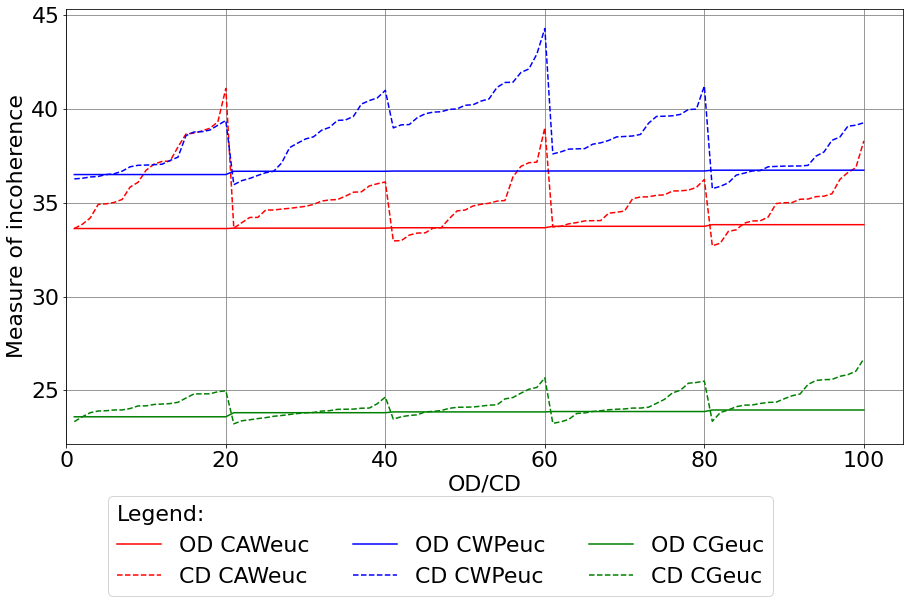

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

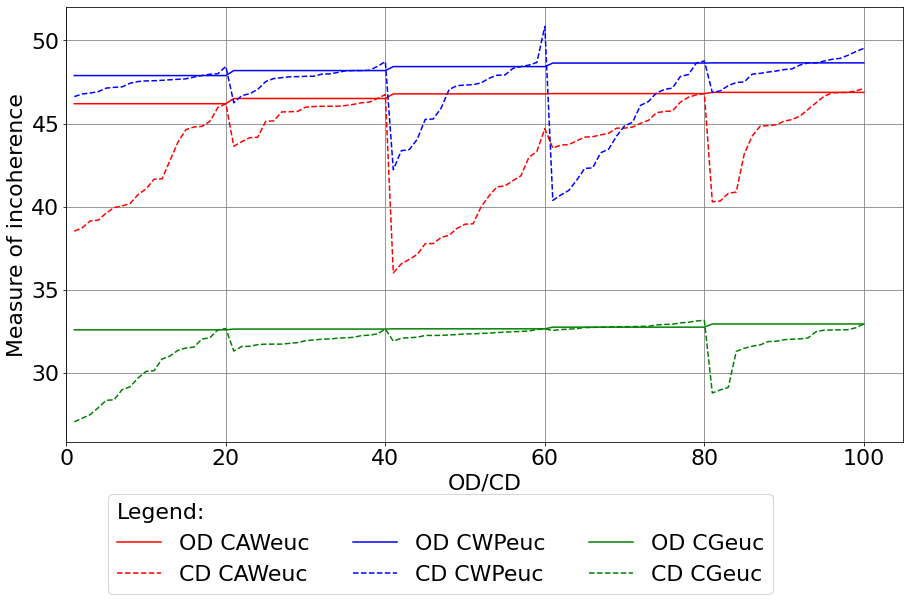

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW[28180:28280], 
                   lista_perturbado_ordenado_CeucCAW[28180:28280], 
                   lista_original_ordenado_CeucCWP[28180:28280], 
                   lista_perturbado_ordenado_CeucCWP[28180:28280], 
                   lista_original_ordenado_CeucCG[28180:28280], 
                   lista_perturbado_ordenado_CeucCG[28180:28280],
                   medida = medida)

# DO central do gráfico com a maior diferença
# id = 56d370aa59d6e414001463c2
# difabs=143.120787302653
# Where was Christina Christian at when she was eliminated from the show?
# Posição gráfico 1412 * 20 = 28240

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 31255.53427825901

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57269016708984140094ca41', 2.1301014640114246, 745, 'Recent studies believe that ctenophores are the sister lineage to what?']
['570e67a80b85d914000d7e92', 3.1638307117280533, 1186, 'Which market in Melbourne remained strong during the Late-2000s financial crisis and resulted in historically high property prices and rent increases?']
['5727f3a63acd2414000df0bb', 3.3421682010997316, 857, 'Despite FDA approval, how much more likely to die are patients who take bedaquiline in addition to the standard TB regimen?']
['56f81eceaef2371900625de5', 3.640882858863236, 1066, 'In what year did Tito travel to the U.S. to visit Washington D.C., amist protest by anti-communist Croat, Serb and Albanian groups?']
['5acd878

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 14692.96644448585

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5acd6c7907355d001abf418c', 0.0040681021554149766, 1209, 'What does not offer better emissions efficiency?']
['5728f9a14b864d1900165160', 0.006180127461760776, 1369, 'What day did the business that first rang a bell to begin in the winter of 2014 in Myanmar open its doors to customers?']
['570e45630b85d914000d7dd4', 0.007077852884926017, 1358, 'How many tonnes of uranium was Australia expected to produce in 2009?']
['572634a1271a42140099d75c', 0.007631683349607954, 1202, "The Orlov Revolt was for which nation's supposed benefit?"]
['5727f604ff5b5019007d994f', 0.009119578770224734, 772, '

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56e08070231d4119001ac200
DO: Who shares the calling code +290 with Saint Helena?
     PRON VERB DET VERB NOUN PROPN ADP PROPN PROPN PUNCT 
  1 - Who shares the calling code +290 with Saint Helena ? [calling(>CAWeuc(DO)=36,4578094482) -> calling(CAWeuc(pertDO)=36,4578094482)] - VERB/VERB-1-1
  2 - Who shares the identity code +290 with Saint Helena ? [calling(>CAWeuc(DO)=36,4578094482) -> identity(CAWeuc(pertDO)=37,8270431095)] - VERB/NOUN-0-0
  3 - Who shares the code code +290 with Saint Helena ? [calling(>CAWeuc(DO)=36,4578094482) -> code(CAWeuc(pertDO)=38,1977302763)] - VERB/NOUN-0-0
  4 - Who shares the phone code +290 with Saint Helena ? [calling(>CAWeuc(DO)=36,4578094482) -> phone(CAWeuc(pertDO)=38,2990279728)] - VERB/NOUN-0-0
  5 - Who shares the telephone code +290 with Saint Helena ? [calling(>CAWeuc(DO)=36,4578094482) -> telephone(CAWeuc(pertDO)=38,7905722724)] - VERB/NOUN-0-0
  6 - Who shares the identification code +290 with Saint Helena ? [calling(>CAWeuc(DO)=36,457

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56e08070231d4119001ac200
DO: Who shares the calling code +290 with Saint Helena?
     PRON VERB DET VERB NOUN PROPN ADP PROPN PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
56e08070231d4119001ac200_pert_0;Who shares the area code +290 with Saint Helena ?;calling;VERB;36,4578094482;40,0830234104;26,9758913040;area;NOUN;41,2053188748;45,2615142822;30,4730110168;0,2994351983;0;0
56e08070231d4119001ac200_pert_1;Who shares the country code +290 with Saint Helena ?;calling;VERB;36,4578094482;40,0830234104;26,9758913040;country;NOUN;43,4012811449;46,1033871121;30,9917898178;0,2422237545;0;0
56e08070231d4119001ac200_pert_2;Who shares the identification code +290 with Saint Helena ?;calling;VERB;36,4578094482;40,0830234104;26,9758913040;identification;NOUN;39,0479528639;42,1547601488;28,3352472305;0,0867387354;0;0
56e08070231d4119001ac200_

##### Usando CAW onde Cm(pertDO)<Cm(DO) *

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 16562.567833773188

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57258041cc50291900b28543', 0.0033187866211008554, 286, 'How long was Lord Sailsbury Prime Minister?']
['5732824557eb1f1400fd2d55', 0.003980772835873836, 704, 'In his farewell speech, what complex did Eisenhower warn the American people of?']
['570fe1765ab6b81900391093', 0.012748024680398373, 1071, 'What year did Dell see its first decline in holiday sales?']
['572f5f7a947a6a140053c8d0', 0.027286052703857422, 345, 'Where was the Baghdad Railway Suppose to connect?']
['5ad3f258604f3c001a3ff8a7', 0.03516859757272783, 580, 'What was the name of the fisherman in lore that saw a vision of Sa

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "56cdd21562d2951400fa68b2"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56d370aa59d6e414001463c2
DO: Where was Christina Christian at when she was eliminated from the show?
     SCONJ AUX PROPN PROPN ADP SCONJ PRON AUX VERB ADP DET NOUN PUNCT 
  1 - Where was Christina Christian at when she was removed from the show ? [eliminated(CAWeuc(DO)=46,7876137098) -> removed(>CAWeuc(pertDO)=36,0179931323)] - VERB/VERB-1-0
  2 - Where was Christina Christian at when she was dismissed from the show ? [eliminated(CAWeuc(DO)=46,7876137098) -> dismissed(>CAWeuc(pertDO)=36,5592220624)] - VERB/VERB-1-0
  3 - Where was Christina Christian at when she was away from the show ? [eliminated(CAWeuc(DO)=46,7876137098) -> away(>CAWeuc(pertDO)=36,8269564311)] - VERB/ADV-0-0
  4 - Where was Christina Christian at when she was banned from the show ? [eliminated(CAWeuc(DO)=46,7876137098) -> banned(>CAWeuc(pertDO)=37,1289585431)] - VERB/VERB-1-0
  5 - Where was Christina Christian at when she was gone from the show ? [eliminated(CAWeuc(DO)=46,7876137098) -> gone(>CAWeuc(pertDO)

In [ ]:
visualizaMedidasEquacoesCSV("5a848a6d7cf838001a46a8eb",
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a848a6d7cf838001a46a8eb
DO: What is a key factor for the ESA?
     PRON AUX DET ADJ NOUN ADP DET PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5a848a6d7cf838001a46a8eb_pert_0;What is a key issue for the ESA ?;factor;NOUN;38,5859115124;41,1465197669;27,2858132256;issue;NOUN;33,3630285263;36,7747615178;24,5186008877;0,1012361273;0;1
5a848a6d7cf838001a46a8eb_pert_1;What is a key element for the ESA ?;factor;NOUN;38,5859115124;41,1465197669;27,2858132256;element;NOUN;33,0422413349;36,9868721962;24,6262533400;0,0888641179;0;1
5a848a6d7cf838001a46a8eb_pert_2;What is a key word for the ESA ?;factor;NOUN;38,5859115124;41,1465197669;27,2858132256;word;NOUN;34,1753761768;37,5702451600;25,0630633036;0,0796592534;0;1
5a848a6d7cf838001a46a8eb_pert_3;What is a key component for the ESA ?;factor;NOUN;38,5859115124;41,1465197669;27,2858132256;c

#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 26976.875244646224

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5727f3a63acd2414000df0bb', 2.5414489776249525, 1261, 'Despite FDA approval, how much more likely to die are patients who take bedaquiline in addition to the standard TB regimen?']
['570e5b3b0dc6ce1900204f8b', 2.705011726277178, 1113, 'Do the Docklands, St. Kilda Road, and Southbank areas feature high-density or low-density forms?']
['57269016708984140094ca41', 2.8567159537113724, 1040, 'Recent studies believe that ctenophores are the sister lineage to what?']
['570e67a80b85d914000d7e92', 3.0614924740481513, 1207, 'Which market in Melbourne remained strong during the Late-2000s financial crisis and resulted in historically high property prices and rent increases?']
['5a4703295fd40d001a27dd3b', 3.3752778

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 12173.840983057382

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['572657b8708984140094c31d', 0.01862803627461318, 961, 'What are two examples of films that are marketed with speeds above their true ISO speed?']
['5728046cff5b5019007d9b05', 0.022972288585854983, 475, 'How are the bit bytes transmitted?']
['572844774b864d190016486e', 0.02691802978515767, 1343, 'Where did bin Laden escape to in Dec 2001?']
['56fae1078f12f31900630225', 0.03013058864708995, 1375, 'People of what nationality export more products from Dubai than Somalis?']
['5727c5984b864d1900163cde', 0.03672129313151373, 1181, 'Who founded the Tibetan Empire?']

Os 5 últimos DOs
id_DO, 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56e08070231d4119001ac200
DO: Who shares the calling code +290 with Saint Helena?
     PRON VERB DET VERB NOUN PROPN ADP PROPN PROPN PUNCT 
  1 - Who shares the calling code +290 with Saint Helena ? [calling(>CWPeuc(DO)=40,0830234104) -> calling(CWPeuc(pertDO)=40,0830234104)] - VERB/VERB-1-1
  2 - Who shares the identity code +290 with Saint Helena ? [calling(>CWPeuc(DO)=40,0830234104) -> identity(CWPeuc(pertDO)=40,6733704885)] - VERB/NOUN-0-0
  3 - Who shares the phone code +290 with Saint Helena ? [calling(>CWPeuc(DO)=40,0830234104) -> phone(CWPeuc(pertDO)=41,9861248016)] - VERB/NOUN-0-0
  4 - Who shares the identification code +290 with Saint Helena ? [calling(>CWPeuc(DO)=40,0830234104) -> identification(CWPeuc(pertDO)=42,1547601488)] - VERB/NOUN-0-0
  5 - Who shares the telephone code +290 with Saint Helena ? [calling(>CWPeuc(DO)=40,0830234104) -> telephone(CWPeuc(pertDO)=42,1831601461)] - VERB/NOUN-0-0
  6 - Who shares the code code +290 with Saint Helena ? [calling(>CWPeuc(

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56e08070231d4119001ac200
DO: Who shares the calling code +290 with Saint Helena?
     PRON VERB DET VERB NOUN PROPN ADP PROPN PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
56e08070231d4119001ac200_pert_0;Who shares the area code +290 with Saint Helena ?;calling;VERB;36,4578094482;40,0830234104;26,9758913040;area;NOUN;41,2053188748;45,2615142822;30,4730110168;0,2994351983;0;0
56e08070231d4119001ac200_pert_1;Who shares the country code +290 with Saint Helena ?;calling;VERB;36,4578094482;40,0830234104;26,9758913040;country;NOUN;43,4012811449;46,1033871121;30,9917898178;0,2422237545;0;0
56e08070231d4119001ac200_pert_2;Who shares the identification code +290 with Saint Helena ?;calling;VERB;36,4578094482;40,0830234104;26,9758913040;identification;NOUN;39,0479528639;42,1547601488;28,3352472305;0,0867387354;0;0
56e08070231d4119001ac200_

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 14803.034261588538

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57289c362ca10214002da4c1', 0.005349254608155718, 648, 'Who was the only female sultana to be enthroned in a Indo-Islamic empire?']
['570e5bf50b85d914000d7e6c', 0.008068175542923939, 467, 'Since what date has Sanskrit been offered as a language option in the U.S.?']
['5725bfc338643c19005acc4f', 0.011408106486001657, 105, 'Who was the Admiral of the German pocket ship?']
['56d118a217492d1400aab91a', 0.012379837036135655, 222, 'When did Kanye West annouce his Pastelle Clothing line?']
['5a5fa126eae51e001ab14b49', 0.018138885498046875, 5, 'What tradition did Marvel embrace?']

Os 5 últi

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a8c3316fd22b3001a8d8643
DO: What was the name of the incomplete standard?
     PRON AUX DET NOUN ADP DET ADJ NOUN PUNCT 
  1 - What was the essence of the incomplete standard ? [name(CWPeuc(DO)=43,2447115050) -> essence(>CWPeuc(pertDO)=34,5497416920)] - NOUN/NOUN-1-0
  2 - What was the cause of the incomplete standard ? [name(CWPeuc(DO)=43,2447115050) -> cause(>CWPeuc(pertDO)=35,1620524195)] - NOUN/NOUN-1-0
  3 - What was the point of the incomplete standard ? [name(CWPeuc(DO)=43,2447115050) -> point(>CWPeuc(pertDO)=35,1993254556)] - NOUN/NOUN-1-0
  4 - What was the meaning of the incomplete standard ? [name(CWPeuc(DO)=43,2447115050) -> meaning(>CWPeuc(pertDO)=35,6291747623)] - NOUN/NOUN-1-0
  5 - What was the effect of the incomplete standard ? [name(CWPeuc(DO)=43,2447115050) -> effect(>CWPeuc(pertDO)=35,6501915720)] - NOUN/NOUN-1-0
  6 - What was the source of the incomplete standard ? [name(CWPeuc(DO)=43,2447115050) -> source(>CWPeuc(pertDO)=35,6579396990)] - NOUN/NOUN-1-0
 

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a8c3316fd22b3001a8d8643
DO: What was the name of the incomplete standard?
     PRON AUX DET NOUN ADP DET ADJ NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5a8c3316fd22b3001a8d8643_pert_0;What was the purpose of the incomplete standard ?;name;NOUN;41,6032948494;43,2447115050;28,7193732791;purpose;NOUN;38,1027557850;39,9651085536;26,4944466485;0,1762604862;0;1
5a8c3316fd22b3001a8d8643_pert_1;What was the meaning of the incomplete standard ?;name;NOUN;41,6032948494;43,2447115050;28,7193732791;meaning;NOUN;33,1797280312;35,6291747623;23,7263344659;0,1325156540;0;1
5a8c3316fd22b3001a8d8643_pert_2;What was the significance of the incomplete standard ?;name;NOUN;41,6032948494;43,2447115050;28,7193732791;significance;NOUN;33,5903148651;36,5537930595;24,3489738041;0,0872576013;0;1
5a8c3316fd22b3001a8d8643_pert_3;What was the nature of the

#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 17889.525444447445

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5727f3a63acd2414000df0bb', 1.7679205355436913, 1339, 'Despite FDA approval, how much more likely to die are patients who take bedaquiline in addition to the standard TB regimen?']
['57269016708984140094ca41', 1.7827312151591173, 1072, 'Recent studies believe that ctenophores are the sister lineage to what?']
['570e5b3b0dc6ce1900204f8b', 1.8137392316545586, 1262, 'Do the Docklands, St. Kilda Road, and Southbank areas feature high-density or low-density forms?']
['570e67a80b85d914000d7e92', 2.0681830319491574, 1292, 'Which market in Melbourne remained strong during the Late-2000s financial crisis and resulted in historically high property prices and rent increases?']
['5733f9cfd058e614000b66ed', 2.31150016

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 8006.244869438708

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56f75e0fa6d7ea1400e1720e', 0.0036553469571174446, 470, 'Malyarchuk found Czech mtDNA lineages were typical of what populations?']
['56fde89119033b140034cdaf', 0.0040089533879239525, 1270, 'What was the nickname of the Manchester Small-Scale Experimental Machine?']
['5727c5984b864d1900163cde', 0.005200703938800899, 795, 'Who founded the Tibetan Empire?']
['5accffbe07355d001abf3150', 0.008293445293720225, 1024, "What was the average attendance of an Arsenal's game in 1913?"]
['572657b8708984140094c31d', 0.016667197732363803, 1078, 'What are two examples of films that are marketed with sp

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56e08070231d4119001ac200
DO: Who shares the calling code +290 with Saint Helena?
     PRON VERB DET VERB NOUN PROPN ADP PROPN PROPN PUNCT 
  1 - Who shares the calling code +290 with Saint Helena ? [calling(>CGeuc(DO)=26,9758913040) -> calling(CGeuc(pertDO)=26,9758913040)] - VERB/VERB-1-1
  2 - Who shares the identity code +290 with Saint Helena ? [calling(>CGeuc(DO)=26,9758913040) -> identity(CGeuc(pertDO)=27,3473083496)] - VERB/NOUN-0-0
  3 - Who shares the phone code +290 with Saint Helena ? [calling(>CGeuc(DO)=26,9758913040) -> phone(CGeuc(pertDO)=28,2626829147)] - VERB/NOUN-0-0
  4 - Who shares the identification code +290 with Saint Helena ? [calling(>CGeuc(DO)=26,9758913040) -> identification(CGeuc(pertDO)=28,3352472305)] - VERB/NOUN-0-0
  5 - Who shares the telephone code +290 with Saint Helena ? [calling(>CGeuc(DO)=26,9758913040) -> telephone(CGeuc(pertDO)=28,3891983032)] - VERB/NOUN-0-0
  6 - Who shares the code code +290 with Saint Helena ? [calling(>CGeuc(DO)=26,9758

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56e08070231d4119001ac200
DO: Who shares the calling code +290 with Saint Helena?
     PRON VERB DET VERB NOUN PROPN ADP PROPN PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
56e08070231d4119001ac200_pert_0;Who shares the area code +290 with Saint Helena ?;calling;VERB;36,4578094482;40,0830234104;26,9758913040;area;NOUN;41,2053188748;45,2615142822;30,4730110168;0,2994351983;0;0
56e08070231d4119001ac200_pert_1;Who shares the country code +290 with Saint Helena ?;calling;VERB;36,4578094482;40,0830234104;26,9758913040;country;NOUN;43,4012811449;46,1033871121;30,9917898178;0,2422237545;0;0
56e08070231d4119001ac200_pert_2;Who shares the identification code +290 with Saint Helena ?;calling;VERB;36,4578094482;40,0830234104;26,9758913040;identification;NOUN;39,0479528639;42,1547601488;28,3352472305;0,0867387354;0;0
56e08070231d4119001ac200_

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

## 3.7 Avaliando o cálculo da incoerência com todas as equações e com a medida de distância manhattan(man)









In [ ]:
medida = 'man'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

### Gráficos

#### Gráfico de linha das medida de coerência Cman dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações





In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW, 
                   lista_perturbado_CmanCAW, 
                   lista_original_CmanCWP, 
                   lista_perturbado_CmanCWP, 
                   lista_original_CmanCG, 
                   lista_perturbado_CmanCG,
                   medida = medida)

In [ ]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCAW, lista_perturbado_CmanCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCWP, lista_perturbado_CmanCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CmanCG, lista_perturbado_CmanCG))

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:200], 
                   lista_perturbado_CmanCAW[0:200], 
                   lista_original_CmanCWP[0:200], 
                   lista_perturbado_CmanCWP[0:200], 
                   lista_original_CmanCG[0:200], 
                   lista_perturbado_CmanCG[0:200],
                   medida = medida)

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:100], 
                   lista_perturbado_CmanCAW[0:100], 
                   lista_original_CmanCWP[0:100], 
                   lista_perturbado_CmanCWP[0:100], 
                   lista_original_CmanCG[0:100], 
                   lista_perturbado_CmanCG[0:100],
                   medida = medida)

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:20], 
                   lista_perturbado_CmanCAW[0:20], 
                   lista_original_CmanCWP[0:20], 
                   lista_perturbado_CmanCWP[0:20], 
                   lista_original_CmanCG[0:20], 
                   lista_perturbado_CmanCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CmanCAW, 
                   lista_perturbado_ordenado_CmanCAW, 
                   lista_original_ordenado_CmanCWP, 
                   lista_perturbado_ordenado_CmanCWP, 
                   lista_original_ordenado_CmanCG, 
                   lista_perturbado_ordenado_CmanCG,
                   medida = medida)

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CmanCAW[0:100], 
                   lista_perturbado_ordenado_CmanCAW[0:100], 
                   lista_original_ordenado_CmanCWP[0:100], 
                   lista_perturbado_ordenado_CmanCWP[0:100], 
                   lista_original_ordenado_CmanCG[0:100], 
                   lista_perturbado_ordenado_CmanCG[0:100],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

In [ ]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_ordenado_CmanCAW, 
                    lista_perturbado_ordenado_CmanCAW,
                    'r',
                    medida = medida)

Sem ordem

In [ ]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CmanCAW, 
                    lista_perturbado_CmanCAW,
                    'r',
                    medida = medida)

In [ ]:
graficoLinhaMedida2Preenchido('Measure of incoherence', 
                              lista_original_ordenado_CmanCAW, 
                              lista_perturbado_ordenado_CmanCAW,
                              medida = 'man')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))